In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import lidar_sim_class_declarations
import importlib

importlib.reload(lidar_sim_class_declarations)

output_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/'

# Leaf Density ratio
# redwood_leaf_density_ratio = 2500  # Leaves per m3
# guiana_leaf_density_ratio = 87.5  # Leaves per m3  Original 8750 number divided by 100 for more realistic density per m3
# guiana_leaf_density_ratio = 8750/20  # Leaves per m3  Original 8750 number divided by 20 for more realistic density per m3 = 437.5

radius = 33.3 / 2
section_range = 0.1  # specifies section size.  (0.1 means section is per 0.1 meters)

In [39]:
def save_objects_to_file(objects_list, filename, subfolder=""):
    # Create the subfolder if it doesn't exist
    if subfolder:
        os.makedirs(subfolder, exist_ok=True)
        filename = os.path.join(subfolder, filename)
        
    # Save the objects to file
    with open(filename, 'wb') as f:
        pickle.dump(objects_list, f)

def load_objects_from_file(filename, subfolder=""):
    # Adjust the filename to include the subfolder
    if subfolder:
        filename = os.path.join(subfolder, filename)
        
    # Load the objects from file
    with open(filename, 'rb') as f:
        objects_list = pickle.load(f)
    
    return objects_list

In [40]:
redwood_tree_objects = load_objects_from_file("redwood_tree_objects.pkl", subfolder="object_data")
guiana_tree_objects = load_objects_from_file("guiana_tree_objects.pkl", subfolder="object_data")
redwood_circle_objects = load_objects_from_file("redwood_circle_objects.pkl", subfolder="object_data")
guiana_circle_objects = load_objects_from_file("guiana_circle_objects.pkl", subfolder="object_data")

for tree in redwood_tree_objects:
    tree.print_attributes()
    print()
for tree in guiana_tree_objects:
    tree.print_attributes()
    print()

tree_index: 1
x_coord: -58.22
y_coord: 39.89
crown_base: 6.53279
crown_d1: 4.75503
crown_d2: 2.70483
crown_d3: 9.46251
crown_base_height: 6.509015
crown_center_height: 11.264045
tree_height: 16.019075
crown_volume: 145.72089163029327
single_leaf_area: 6e-05
total_leaf_area: 21.858133744543988
total_tree_branch_area: 5.091073367371114
total_tree_stem_area: 0
total_tree_ground_area: 22.984222754161376
total_tree_canopy_veg_area: 26.9492071119151
leaf_density: 2500
branch_scale: 0.01

tree_index: 2
x_coord: -58.43
y_coord: 32.12
crown_base: 7.02676
crown_d1: 5.83397
crown_d2: 3.09267
crown_d3: 11.6096
crown_base_height: 6.99759
crown_center_height: 12.83156
tree_height: 18.66553
crown_volume: 233.732962642793
single_leaf_area: 6e-05
total_leaf_area: 35.05994439641895
total_tree_branch_area: 8.083898341710007
total_tree_stem_area: 0
total_tree_ground_area: 30.048101375580398
total_tree_canopy_veg_area: 43.14384273812895
leaf_density: 2500
branch_scale: 0.01

tree_index: 3
x_coord: -62.59
y

In [41]:
for circle in redwood_circle_objects:
    circle.print_attributes()
    print()
for circle in guiana_circle_objects:
    circle.print_attributes()
    print()

circle_name: Circle(3, 1)
x_coord: -33.300000
y_coord: 33.300000
row: 3
column: 1
tree_indices: [ 7 14 15 16 17 19 20 26 27 28 29 37 39 51 53]
crown_vol_in_circle: [ 248.26696059    0.32523409   34.91988234  495.41275132  504.32625546
  171.29795503  401.21370334  150.14615303 1002.6985605   337.14874305
  515.6410405  4884.29356445  441.46961146  504.25205435  410.04984457]
crown_percentages: [0.39477425 0.00057048 0.15108792 0.99471357 1.         0.69163379
 0.08520866 0.32263391 0.96574886 1.         0.50879085 1.
 1.         1.         0.84088965]
tree_heights: [25.94412 26.03559 19.14973 23.71524 23.94105 19.64225 41.67815 23.85574
 29.03983 20.77117 29.2986  42.18075 23.12683 25.44789 23.62493]
single_leaf_areas: [0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006
 0.00006 0.00006 0.00006 0.00006 0.00006 0.00006]
adj_branch_areas: [  8.34306024   0.01131375   1.26253713  16.58470654  16.9899038
   6.02454366  13.53606327   5.29658866  33.22261348  11.2597211


In [42]:
def calculate_Li_dz(circle, trees, section_range, leaf_density):
    num_trees = len(circle.tree_indices)
    max_tree_height = max(trees[tree_index - 1].tree_height for tree_index in circle.tree_indices)

    circle.Li_dz_leaf = np.zeros((num_trees, math.ceil(max_tree_height / section_range) + 1))
    circle.Li_dz_branch = np.zeros((num_trees, math.ceil(max_tree_height / section_range) + 1))
    circle.Fa_array = np.zeros((num_trees, math.ceil(max_tree_height / section_range) + 1))
    circle.Fa_b_array = np.zeros((num_trees, math.ceil(max_tree_height / section_range) + 1))
    circle.Fa_leaf_branch_per_tree = np.zeros(num_trees)
    
    # Create the array of heights by section range
    circle.tree_height_array = np.arange(0, max_tree_height + section_range, section_range)[:math.ceil(max_tree_height / section_range) + 1]
    tree_height_array = circle.tree_height_array

    # with np.printoptions(threshold=np.inf):
    #     print(f"Max Tree Height: {max_tree_height}")
    #     print(circle.tree_height_array)
    
    for tree in trees:
        single_leaf_area = tree.single_leaf_area
        break

    Fa = leaf_density * single_leaf_area
    circle.new_Fa = Fa
    # print(f"circle_name: {circle.circle_name}")
    LAI = circle.LAI_with_branch
    LAI_b = circle.LAI_without_branch
    print(f"LAI_with_branch: {LAI}")
    print(f"LAI_without_branch: {LAI_b}")
    # print(f"Fa = leaf_density: {leaf_density} * single_leaf_area: {single_leaf_area}")

    for index, tree_index in enumerate(circle.tree_indices):
        tree = trees[tree_index - 1]  # Adjust for 0-based index

        tree_height = tree.tree_height
        crown_volume = tree.crown_volume
        total_branch_area = tree.total_tree_branch_area
        crown_percentage = circle.crown_percentages[index]
        crown_base_height = tree.crown_base_height
        crown_radius = tree.crown_d2
        crown_center_height = tree.crown_center_height
        crown_vertical_radius = tree_height - crown_center_height

        Fa_leaf_branch_per_tree = Fa + total_branch_area/crown_volume
        # print(f"Tree {tree_index}:")
        # print(f"4/3 * crown_radius: {crown_radius} ^2 * crown_vertical_radius: {crown_vertical_radius} = crown_volume: {crown_volume}")
        # print (f"Fa leaf only: {Fa} + total_branch_area: {total_branch_area} / crown_volume: {crown_volume}")
        # print (f"Fa leaf and branch: {Fa_leaf_branch_per_tree}")
        circle.Fa_leaf_branch_per_tree[index] = Fa_leaf_branch_per_tree

        Fa_array, Fa_b_array, Li_dz_leaf, Li_dz_branch = calculate_Li_dz_per_section(Fa, Fa_leaf_branch_per_tree, crown_percentage, crown_base_height, crown_radius, crown_center_height, crown_vertical_radius, tree_height, tree_height_array, section_range)
        circle.Li_dz_leaf[index, :len(Li_dz_leaf)] = Li_dz_leaf
        circle.Li_dz_branch[index, :len(Li_dz_branch)] = Li_dz_branch
        circle.Fa_array[index, :len(Fa_array)] = Fa_array
        circle.Fa_b_array[index, :len(Fa_b_array)] = Fa_b_array
    
    print()

def calculate_Li_dz_per_section(Fa, Fa_leaf_branch_per_tree, crown_percentage, crown_base_height, crown_radius, crown_center_height, crown_vertical_radius, tree_height, tree_height_array, section_range):
    # Calculate the number of sections
    num_sections = len(tree_height_array)

    # Initialize NumPy arrays to store leaf area, veg area, and volume per range height
    Li_dz_leaf_per_range = np.zeros(num_sections, dtype=float)
    Li_dz_branch_per_range = np.zeros(num_sections, dtype=float)
    Fa_array = np.zeros(num_sections, dtype=float)
    Fa_b_array = np.zeros(num_sections, dtype=float)

    # Calculate the leaf area, veg area, and volume for the rest of the ranges
    for i in range(int(crown_base_height / section_range), int(tree_height / section_range)):
        Li_dz_leaf_per_range_single = Fa * math.pi * crown_radius**2 * abs(1- ((tree_height_array[i] - crown_center_height)/crown_vertical_radius)**2)
        Li_dz_leaf_per_range[i] += Li_dz_leaf_per_range_single * crown_percentage
        Li_dz_branch_per_range_single = Fa_leaf_branch_per_tree * math.pi * crown_radius**2 * abs(1- ((tree_height_array[i] - crown_center_height)/crown_vertical_radius)**2)
        Li_dz_branch_per_range[i] += Li_dz_branch_per_range_single * crown_percentage
        Fa_array[i] = Fa
        Fa_b_array[i] = Fa_leaf_branch_per_tree

    # Calculate the proportion of the first range occupied by the crown
    proportion_first_range = 1.0 - (crown_base_height % section_range)
    # Calculate the proportion of the last range occupied by the crown
    proportion_last_range = (tree_height % section_range) / section_range

    if proportion_first_range != 0:
        Li_dz_leaf_per_range[int(crown_base_height / section_range)] *=  proportion_first_range
        Li_dz_branch_per_range[int(crown_base_height / section_range)] *= proportion_first_range
    if proportion_last_range != 0:
        Li_dz_leaf_per_range[int(tree_height / section_range)] *= proportion_last_range
        Li_dz_branch_per_range[int(tree_height / section_range)] *= proportion_last_range

    return Fa_array, Fa_b_array, Li_dz_leaf_per_range, Li_dz_branch_per_range

In [43]:
for tree in redwood_tree_objects:
    redwood_leaf_density_ratio = tree.leaf_density
    break

for circle in redwood_circle_objects:
    calculate_Li_dz(circle, redwood_tree_objects, section_range, redwood_leaf_density_ratio)
    circle.total_Li_dz_leaf = np.sum(circle.Li_dz_leaf, axis=0)/circle.pixel_area
    circle.total_Li_dz_branch = np.sum(circle.Li_dz_branch, axis=0)/circle.pixel_area
    circle.total_Fa = np.sum(circle.Fa_array, axis=0)/circle.pixel_area
    circle.total_Fa_b = np.sum(circle.Fa_b_array, axis=0)/circle.pixel_area
    circle.acc_LAI_leaf = np.cumsum(circle.total_Li_dz_leaf[::-1])[::-1] * section_range
    circle.acc_LAI_branch = np.cumsum(circle.total_Li_dz_branch[::-1])[::-1] * section_range

    with np.printoptions(threshold=np.inf):
        print(f"Circle: {circle.circle_name}")
        print(np.sum(circle.Li_dz_leaf)/circle.new_Fa)
        print(np.sum(circle.total_Li_dz_leaf * circle.pixel_area/circle.new_Fa))
        # print(circle.total_Li_dz_leaf)
        # print(circle.total_Li_dz_branch)
        # print(circle.total_Fa)
        # print(circle.total_Fa_b)
        print(circle.acc_LAI_leaf)

for tree in guiana_tree_objects:
    guiana_leaf_density_ratio = tree.leaf_density
    break

for circle in guiana_circle_objects:
    calculate_Li_dz(circle, guiana_tree_objects, section_range, guiana_leaf_density_ratio)
    circle.total_Li_dz_leaf = np.sum(circle.Li_dz_leaf, axis=0)/circle.pixel_area
    circle.total_Li_dz_branch = np.sum(circle.Li_dz_branch, axis=0)/circle.pixel_area
    circle.total_Fa = np.sum(circle.Fa_array, axis=0)/circle.pixel_area
    circle.total_Fa_b = np.sum(circle.Fa_b_array, axis=0)/circle.pixel_area
    circle.acc_LAI_leaf = np.cumsum(circle.total_Li_dz_leaf[::-1])[::-1] * section_range
    circle.acc_LAI_branch = np.cumsum(circle.total_Li_dz_branch[::-1])[::-1] * section_range

LAI_with_branch: 2.13960801606531
LAI_without_branch: 1.7397913153596438

Circle: Circle(3, 1)
101013.79589537163
101013.79589537163
[1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707
 1.73977707 1.73977707 1.73977707 1.73977707 1.73977707 1.73977644
 1.73977464 1.73977044 1.73976387 1.73974428 1.73973286 1.73969

In [44]:
for circle in guiana_circle_objects:
    calculate_Li_dz(circle, guiana_tree_objects, section_range, guiana_leaf_density_ratio)
    circle.total_Li_dz_leaf = np.sum(circle.Li_dz_leaf, axis=0)/circle.pixel_area
    circle.total_Li_dz_branch = np.sum(circle.Li_dz_branch, axis=0)/circle.pixel_area
    circle.total_Fa = np.sum(circle.Fa_array, axis=0)/circle.pixel_area
    circle.total_Fa_b = np.sum(circle.Fa_b_array, axis=0)/circle.pixel_area
    circle.acc_LAI_leaf = np.cumsum(circle.total_Li_dz_leaf[::-1])[::-1] * section_range
    circle.acc_LAI_branch = np.cumsum(circle.total_Li_dz_branch[::-1])[::-1] * section_range

    with np.printoptions(threshold=np.inf):
        print(f"Circle: {circle.circle_name}")
        # print(circle.total_Li_dz_leaf)
        print("total_Li_dz_branch", circle.total_Li_dz_branch)
        # print(circle.total_Fa)
        # print(circle.total_Fa_b)
        # print(circle.acc_LAI_branch)

LAI_with_branch: 7.288367679520273
LAI_without_branch: 5.797348646515122

Circle: Circle(3, 1)
total_Li_dz_branch [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00057367
 0.00079446 0.00211737 0.00336967 0.00455137 0.00566246 0.00670295
 0.00767283 0.00857211 0.00944257 0.01018181 0.01093405 0.01161277
 0.01221797 0.01292011 0.01494462 0.01683315 0.01968268 0.02234973
 0.02483432 0.02713644 0.029

In [45]:
for circle in redwood_circle_objects:
    print(f"Circle Name: {circle.circle_name}")
    print(f"Leaf Fa: {circle.new_Fa}")

    # with np.printoptions(threshold=np.inf):

    for i, tree_index in enumerate(circle.tree_indices):
        print(f"Tree {tree_index} Leaf and Branch Fa: {circle.Fa_leaf_branch_per_tree[i]}")


Circle Name: Circle(3, 1)
Leaf Fa: 0.15
Tree 7 Leaf and Branch Fa: 0.18360519750474033
Tree 14 Leaf and Branch Fa: 0.18478648545042464
Tree 15 Leaf and Branch Fa: 0.18615525148169
Tree 16 Leaf and Branch Fa: 0.18347654354678886
Tree 17 Leaf and Branch Fa: 0.18368831904494565
Tree 19 Leaf and Branch Fa: 0.1851699683885184
Tree 20 Leaf and Branch Fa: 0.1837377890006086
Tree 26 Leaf and Branch Fa: 0.1852762195536367
Tree 27 Leaf and Branch Fa: 0.18313320153161147
Tree 28 Leaf and Branch Fa: 0.18339689478244847
Tree 29 Leaf and Branch Fa: 0.1835933519993673
Tree 37 Leaf and Branch Fa: 0.18524404927669544
Tree 39 Leaf and Branch Fa: 0.18463930778997548
Tree 51 Leaf and Branch Fa: 0.1846959468752962
Tree 53 Leaf and Branch Fa: 0.18274060207823398
Circle Name: Circle(3, 2)
Leaf Fa: 0.15
Tree 25 Leaf and Branch Fa: 0.18371016081882796
Tree 52 Leaf and Branch Fa: 0.18475118508571592
Tree 54 Leaf and Branch Fa: 0.18484191112239073
Tree 64 Leaf and Branch Fa: 0.1837756141426064
Tree 65 Leaf and B

In [46]:
for circle in guiana_circle_objects:
    print(f"Circle Name: {circle.circle_name}")
    print(f"Leaf Fa: {circle.new_Fa}")

    # with np.printoptions(threshold=np.inf):

    for i, tree_index in enumerate(circle.tree_indices):
        print(f"Tree {tree_index} Leaf and Branch Fa: {circle.Fa_leaf_branch_per_tree[i]}")

Circle Name: Circle(3, 1)
Leaf Fa: 3.384315
Tree 8 Leaf and Branch Fa: 4.290421066554616
Tree 12 Leaf and Branch Fa: 4.237540022652846
Tree 19 Leaf and Branch Fa: 4.293659734120626
Tree 30 Leaf and Branch Fa: 4.2805405566718635
Tree 44 Leaf and Branch Fa: 4.316952473961532
Tree 59 Leaf and Branch Fa: 4.3417917553388605
Tree 65 Leaf and Branch Fa: 4.302093556125683
Tree 70 Leaf and Branch Fa: 4.380629239162316
Tree 73 Leaf and Branch Fa: 4.357610223973245
Tree 75 Leaf and Branch Fa: 4.213493420452911
Tree 76 Leaf and Branch Fa: 4.281646437220697
Tree 90 Leaf and Branch Fa: 4.2945830039791835
Tree 92 Leaf and Branch Fa: 4.3621629651734555
Tree 95 Leaf and Branch Fa: 4.302076729966075
Tree 98 Leaf and Branch Fa: 4.300211032140324
Tree 109 Leaf and Branch Fa: 4.24740559164771
Tree 110 Leaf and Branch Fa: 4.271369275121625
Tree 112 Leaf and Branch Fa: 4.190715641429175
Tree 115 Leaf and Branch Fa: 4.243987654632932
Tree 116 Leaf and Branch Fa: 4.2946451852365986
Tree 119 Leaf and Branch Fa:

In [47]:
def plot_circle_fp_with_subplots(circle_objects, section_range, data_type, sup_title, path, file_prefix):
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    fig, axes = plt.subplots(3, 3, figsize=(20, 20))

    for i, (circle, ax) in enumerate(zip(circle_objects, axes.flat)):
        if data_type == 'leaf':
            x_data = circle.total_Li_dz_leaf
            y_data = np.arange(len(circle.total_Li_dz_leaf)) * section_range

            ax.plot(x_data, y_data, color='blue')
            ax.set_title(f"Circle: {circle.circle_name}")
            ax.set_xlabel('Total Leaf Area profile')
            ax.set_ylabel('Height (m)')
        elif data_type == 'veg':
            x_data = circle.total_Li_dz_branch
            y_data = np.arange(len(circle.total_Li_dz_branch)) * section_range

            ax.plot(x_data, y_data, color='red')
            ax.set_title(f"Circle: {circle.circle_name}")
            ax.set_xlabel('Total Leaf and Branch Area profile')
            ax.set_ylabel('Height (m)')
        else:
            print("Invalid data type. Please provide either 'leaf' or 'veg'.")
            return
        
        max_data_length = max(len(circle.total_Li_dz_leaf) for circle in circle_objects)
        ax.set_ylim(0, max_data_length * section_range)

        # ax.set_ylim(0, len(circle.total_leaf_area_per_meter_range) * section_range)  # Set y-axis limits
        
        # Rotate x-axis tick labels
        ax.tick_params(axis='x', rotation=30)
    
    fig.suptitle(sup_title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust rect for title position
    
    # Save the figure as PNG with a custom filename
    fp_path = path + "foliage_profile/"

    if not os.path.exists(fp_path):
        os.makedirs(fp_path)

    fig.savefig(f"{fp_path}{file_prefix}_{data_type}_foliage_profile.png")

    plt.show()

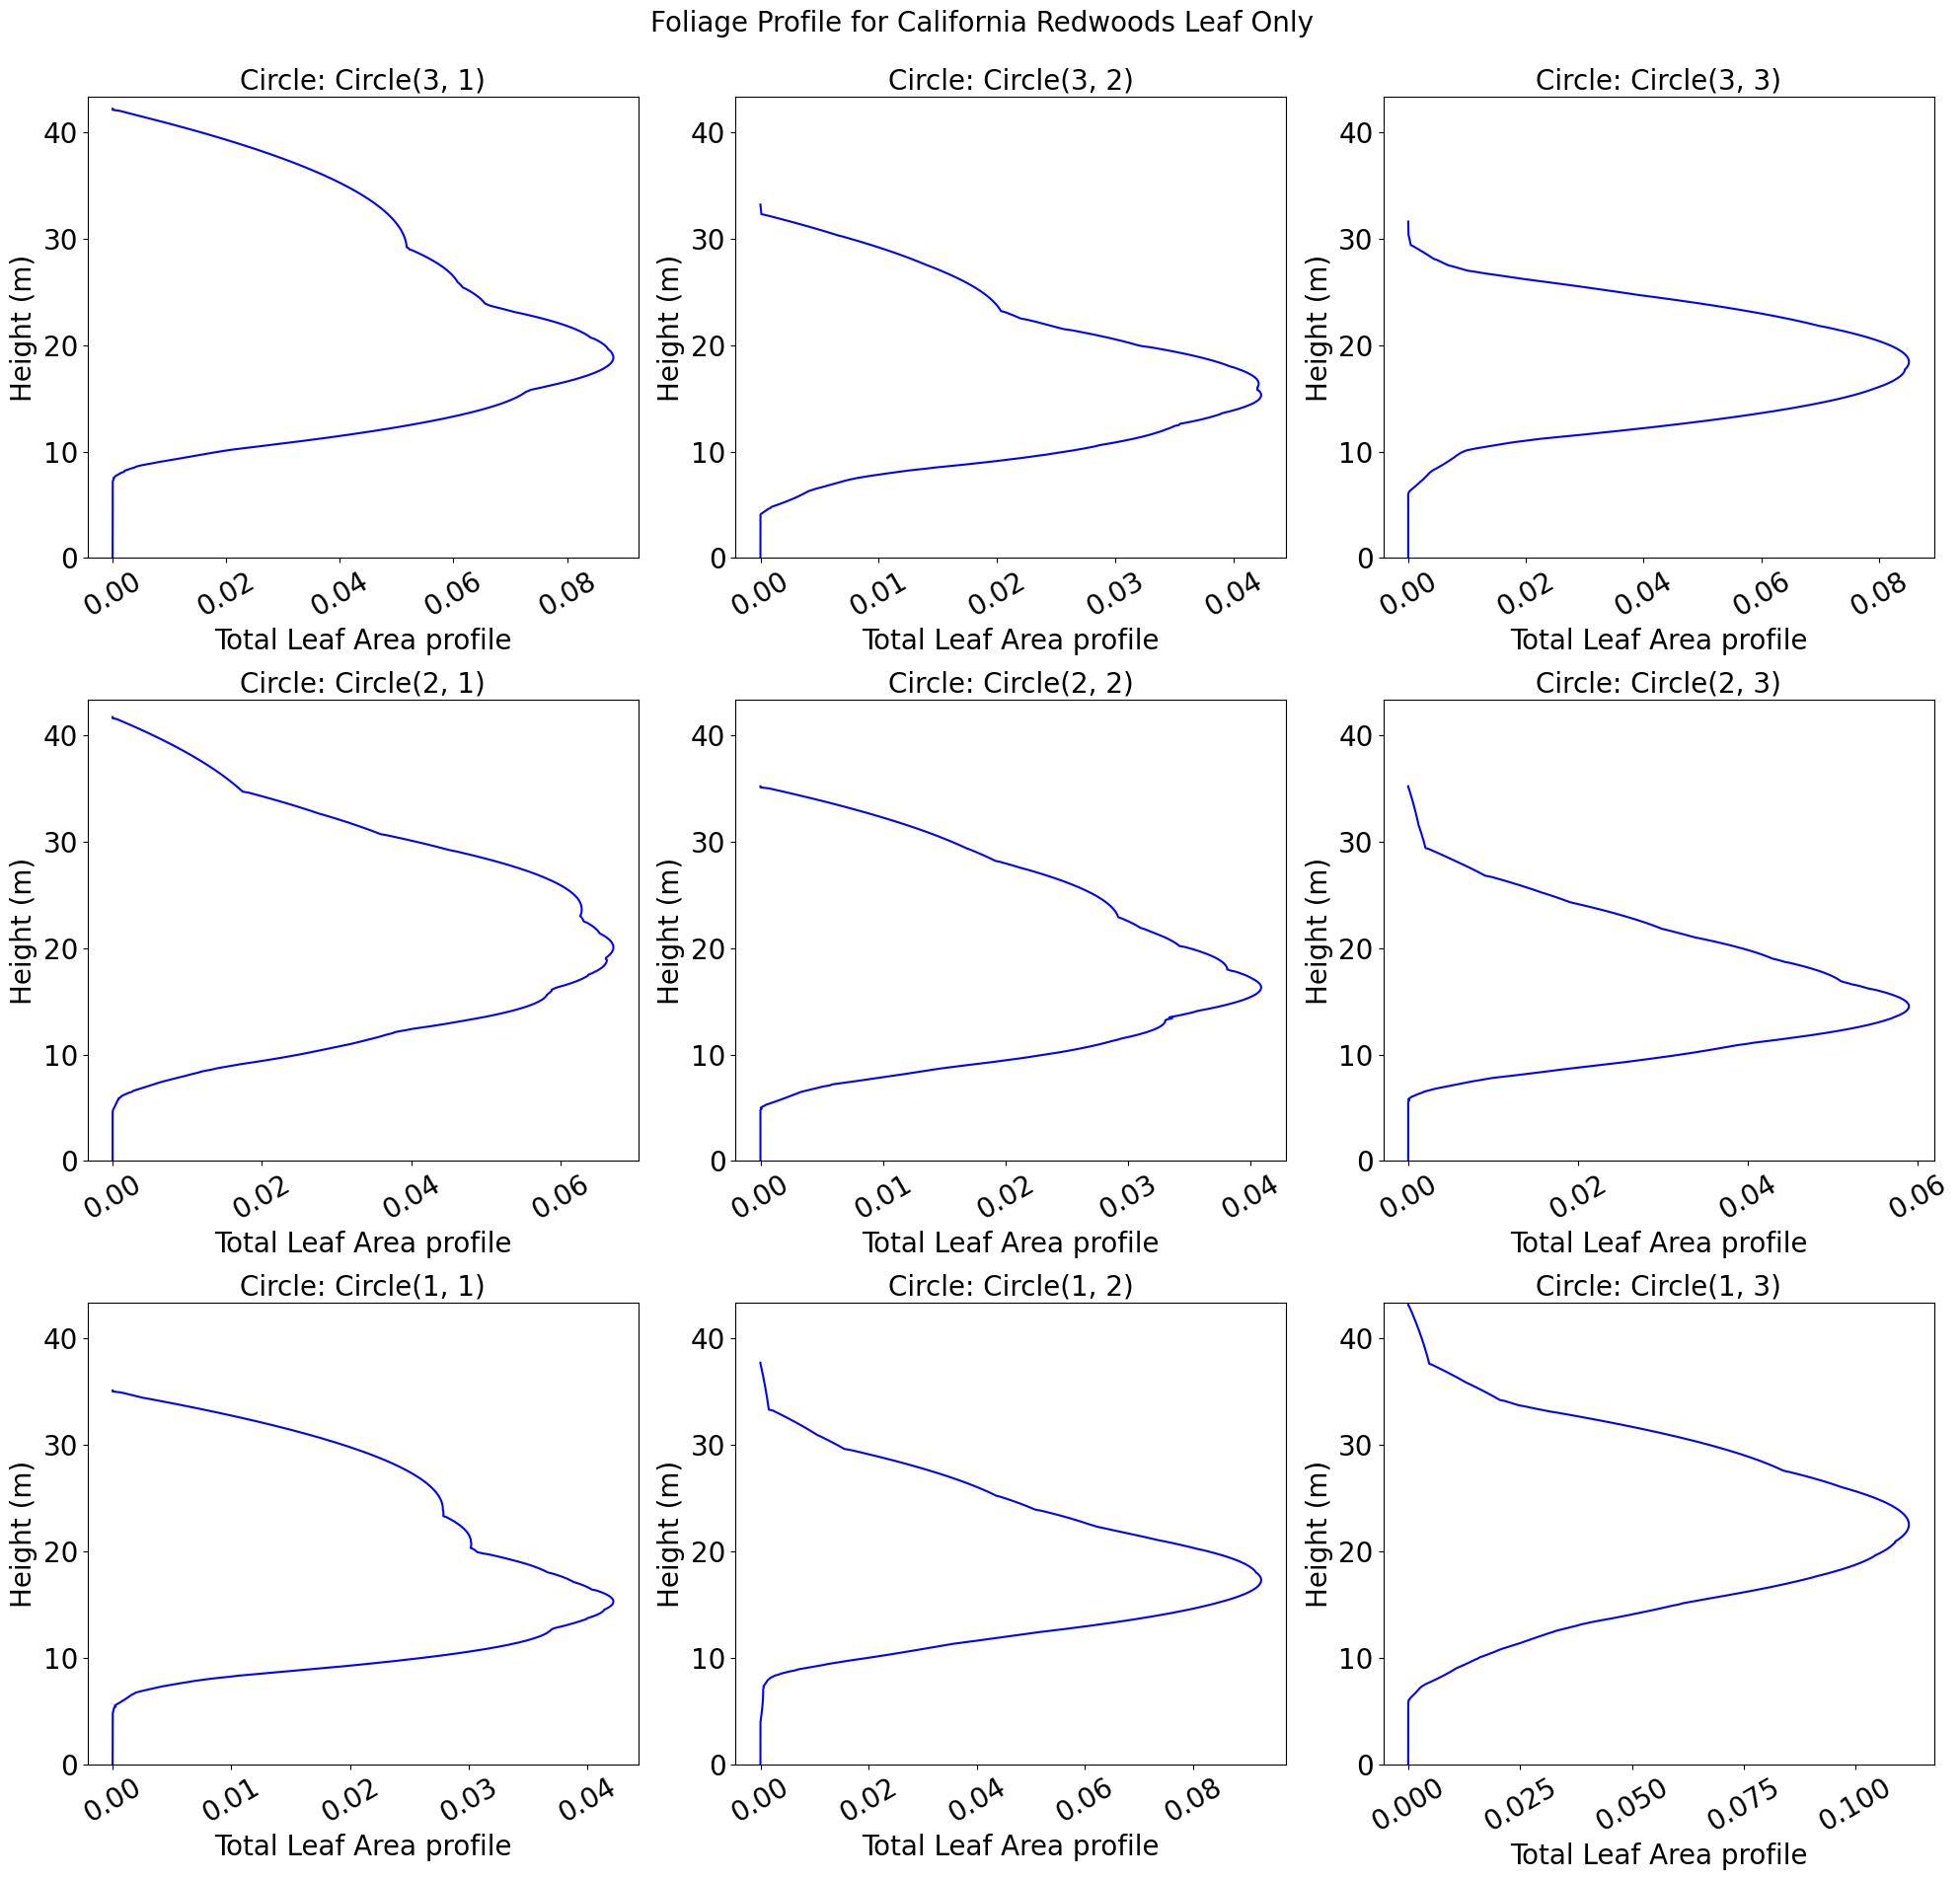

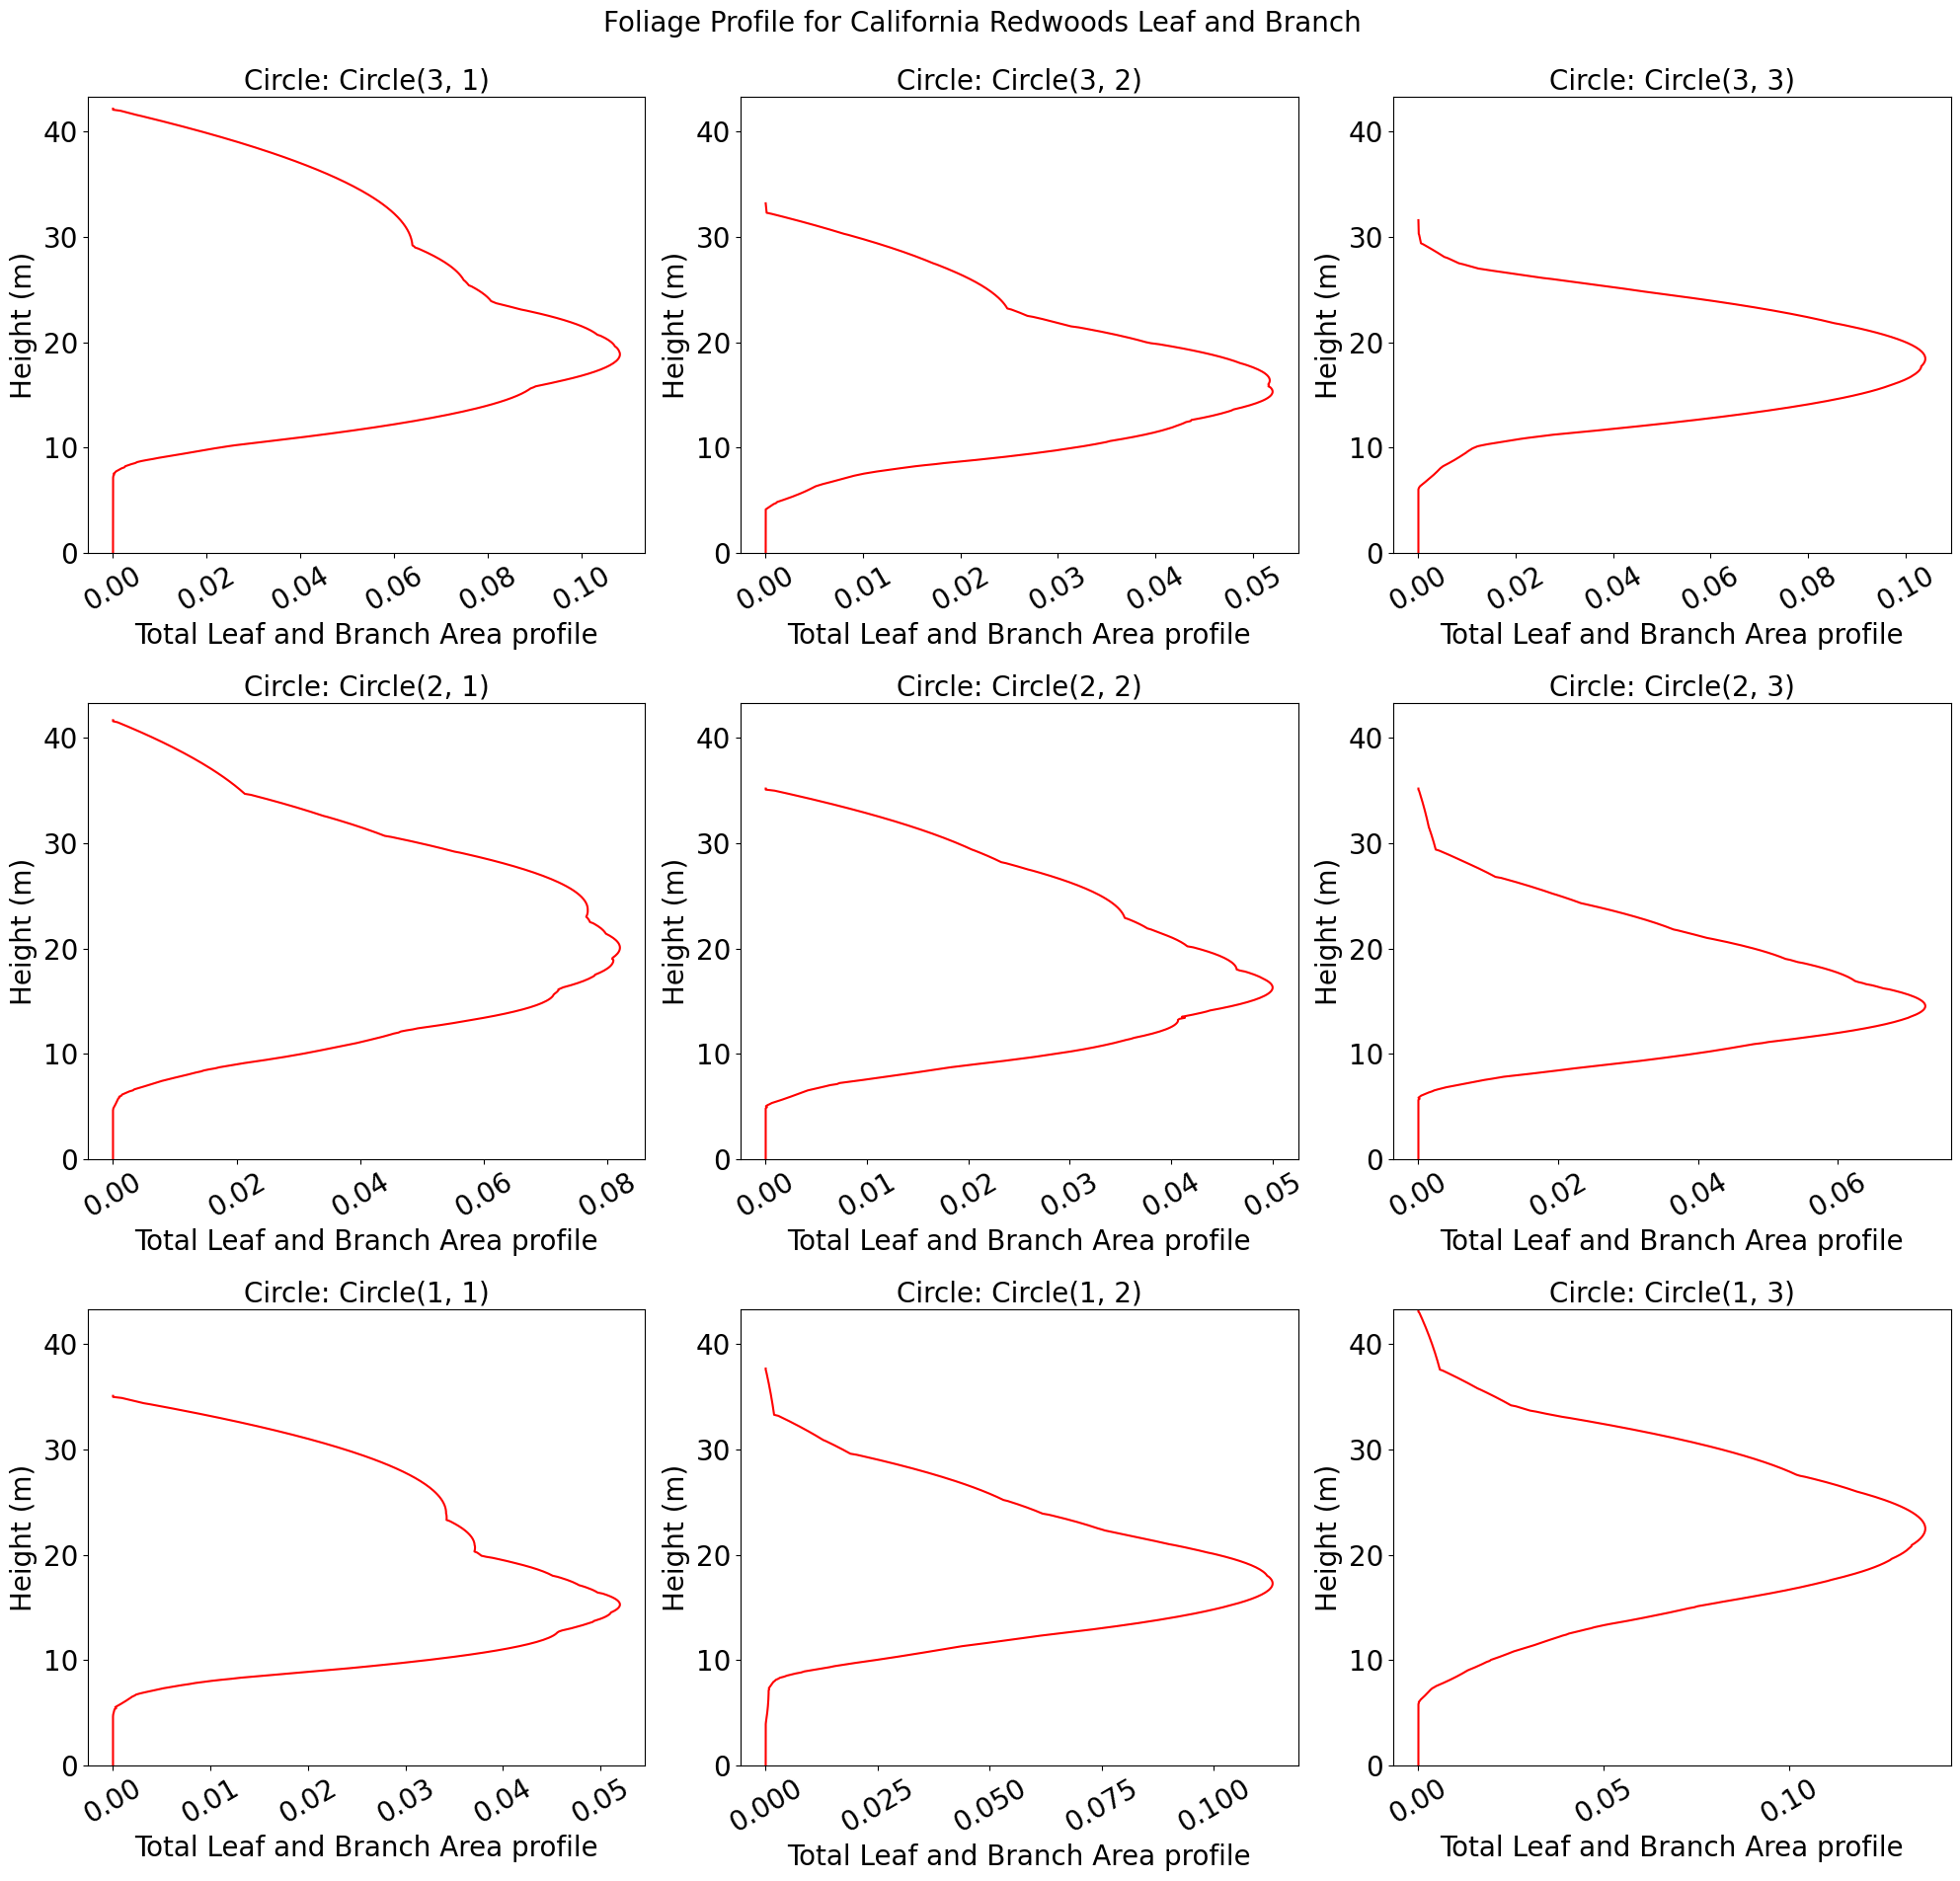

In [48]:
# Plot total leaf only foliage profile per meter for each circle
plot_circle_fp_with_subplots(redwood_circle_objects, section_range, 'leaf', 'Foliage Profile for California Redwoods Leaf Only', output_path, 'redwood')

# Plot total leaf and branch foliage profile per meter for each circle
plot_circle_fp_with_subplots(redwood_circle_objects, section_range, 'veg', 'Foliage Profile for California Redwoods Leaf and Branch', output_path, 'redwood')

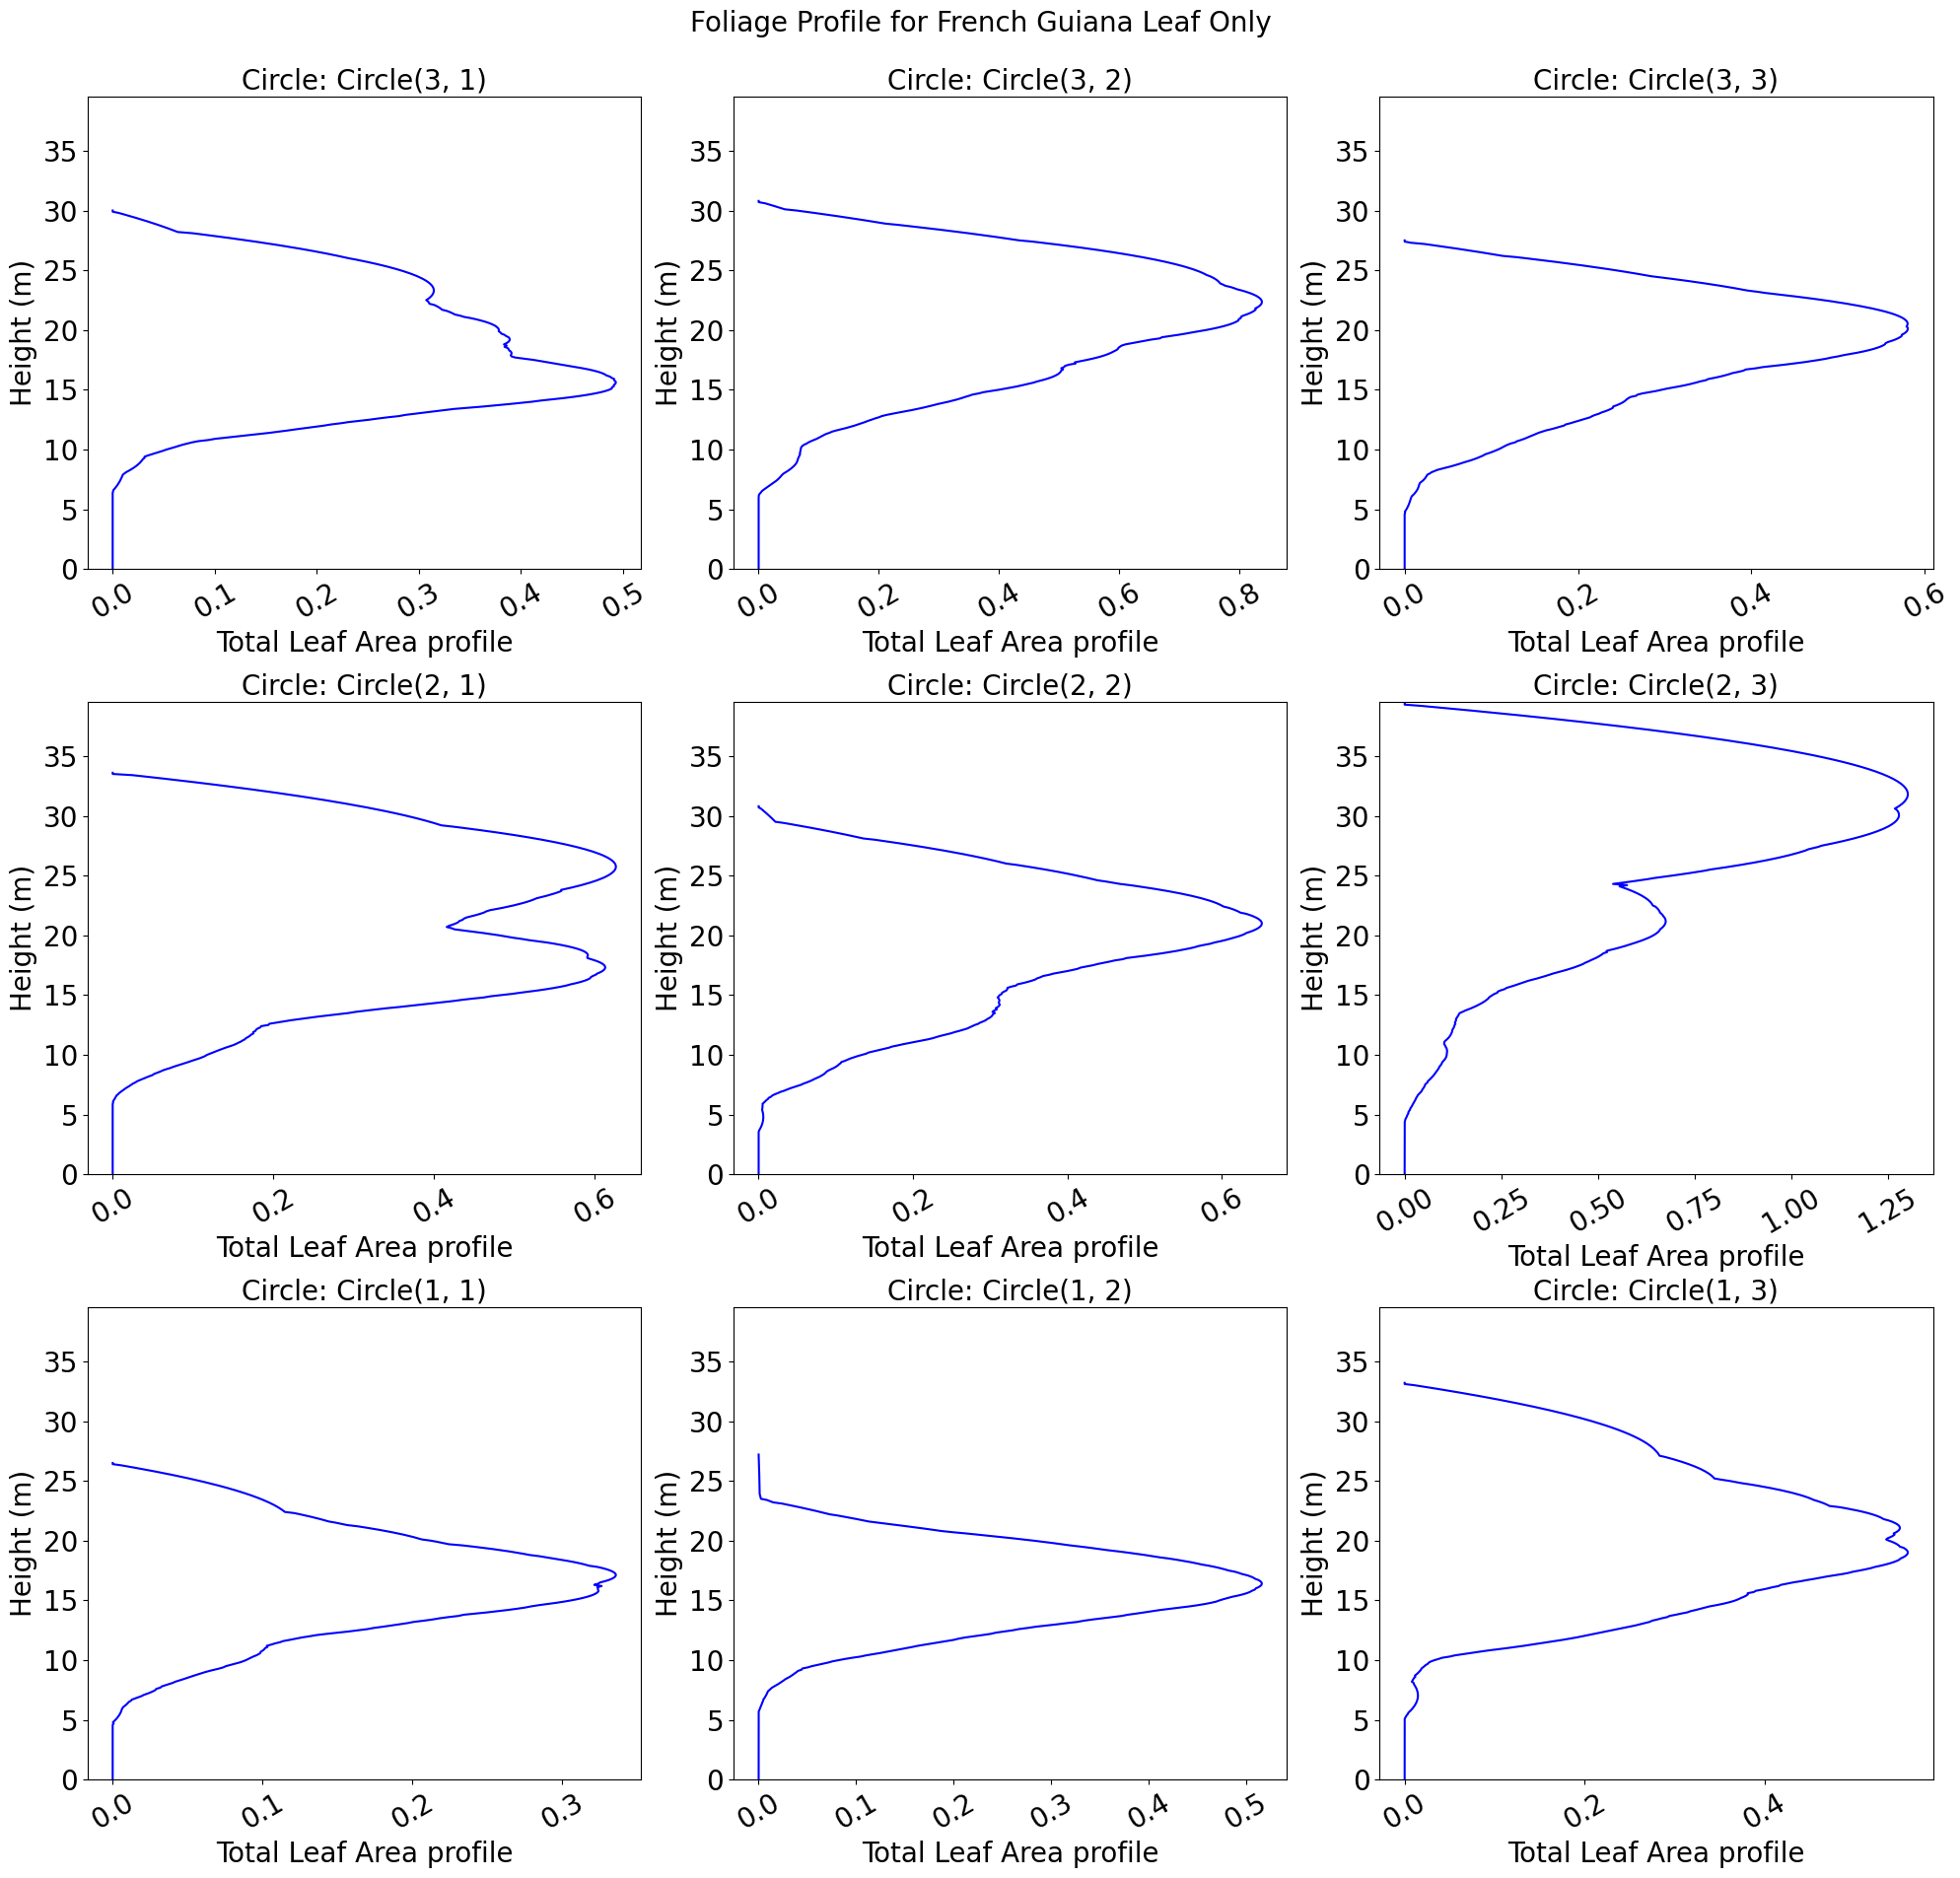

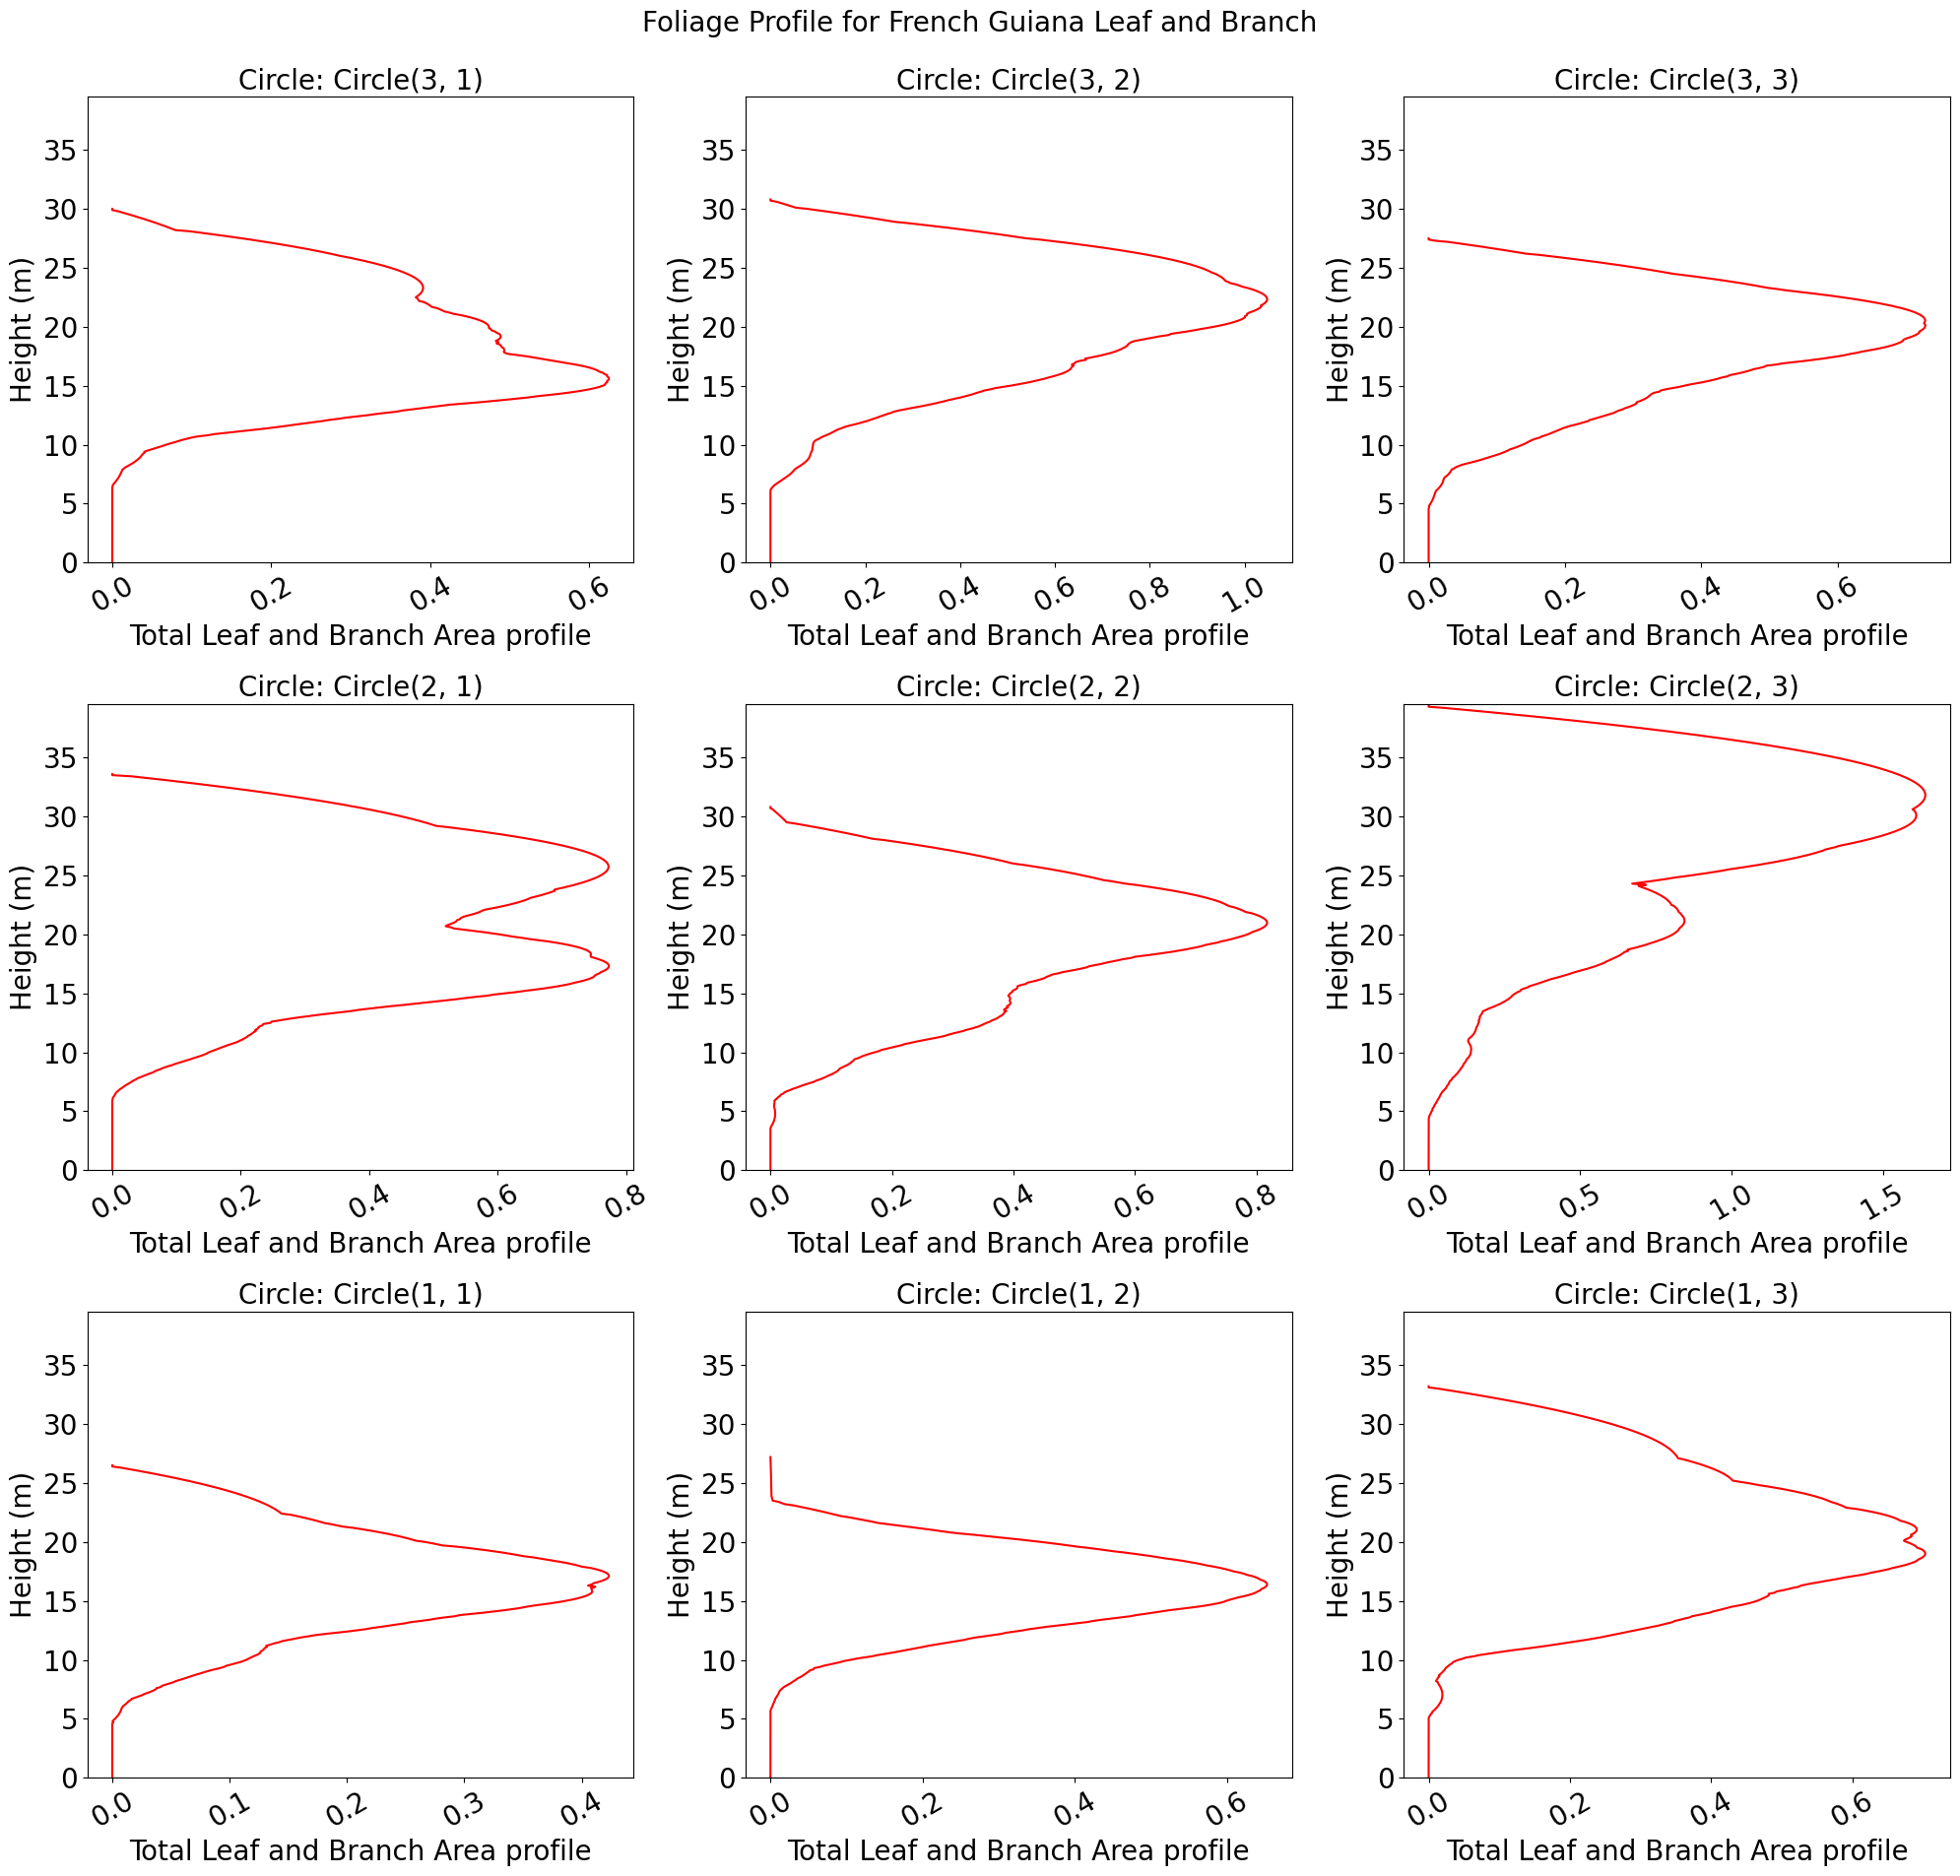

In [49]:
# Plot total leaf only foliage profile per meter for each circle
plot_circle_fp_with_subplots(guiana_circle_objects, section_range, 'leaf', 'Foliage Profile for French Guiana Leaf Only', output_path, 'guiana')

# Plot total leaf and branch foliage profile per meter for each circle
plot_circle_fp_with_subplots(guiana_circle_objects, section_range, 'veg', 'Foliage Profile for French Guiana Leaf and Branch', output_path, 'guiana')

In [50]:
def plot_circle_acc_LAI_with_subplots(circle_objects, section_range, data_type, sup_title, path, file_prefix):
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    fig, axes = plt.subplots(3, 3, figsize=(20, 20))

    for i, (circle, ax) in enumerate(zip(circle_objects, axes.flat)):
        if data_type == 'leaf':
            x_data = circle.acc_LAI_leaf
            y_data = np.arange(len(circle.acc_LAI_leaf)) * section_range

            ax.plot(x_data, y_data, color='blue')
            ax.set_title(circle.circle_name)
            ax.set_xlabel('Accumulated LAI for leaf only')
            ax.set_ylabel('Height (m)')
        elif data_type == 'veg':
            x_data = circle.acc_LAI_branch
            y_data = np.arange(len(circle.acc_LAI_branch)) * section_range

            ax.plot(x_data, y_data, color='red')
            ax.set_title(circle.circle_name)
            if (file_prefix == "redwood"):
                ax.set_xlabel('Accumulated LAI (branch * 0.01 scale)')
            else:
                ax.set_xlabel('Accumulated LAI leaf and branch')
            ax.set_ylabel('Height (m)')
        else:
            print("Invalid data type. Please provide either 'leaf' or 'veg'.")
            return
        
        max_data_length = max(len(circle.acc_LAI_leaf) for circle in circle_objects)
        ax.set_ylim(0, max_data_length * section_range)

        # ax.set_ylim(0, len(circle.total_leaf_area_per_meter_range) * section_range)  # Set y-axis limits
        
        # Rotate x-axis tick labels
        ax.tick_params(axis='x', rotation=30)
    
    fig.suptitle(sup_title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust rect for title position
    
    # Save the figure as PNG with a custom filename
    acc_LAI_path = path + "acc_LAI/"
    
    if not os.path.exists(acc_LAI_path):
        os.makedirs(acc_LAI_path)

    fig.savefig(f"{acc_LAI_path}{file_prefix}_{data_type}_acc_LAI.png")

    plt.show()

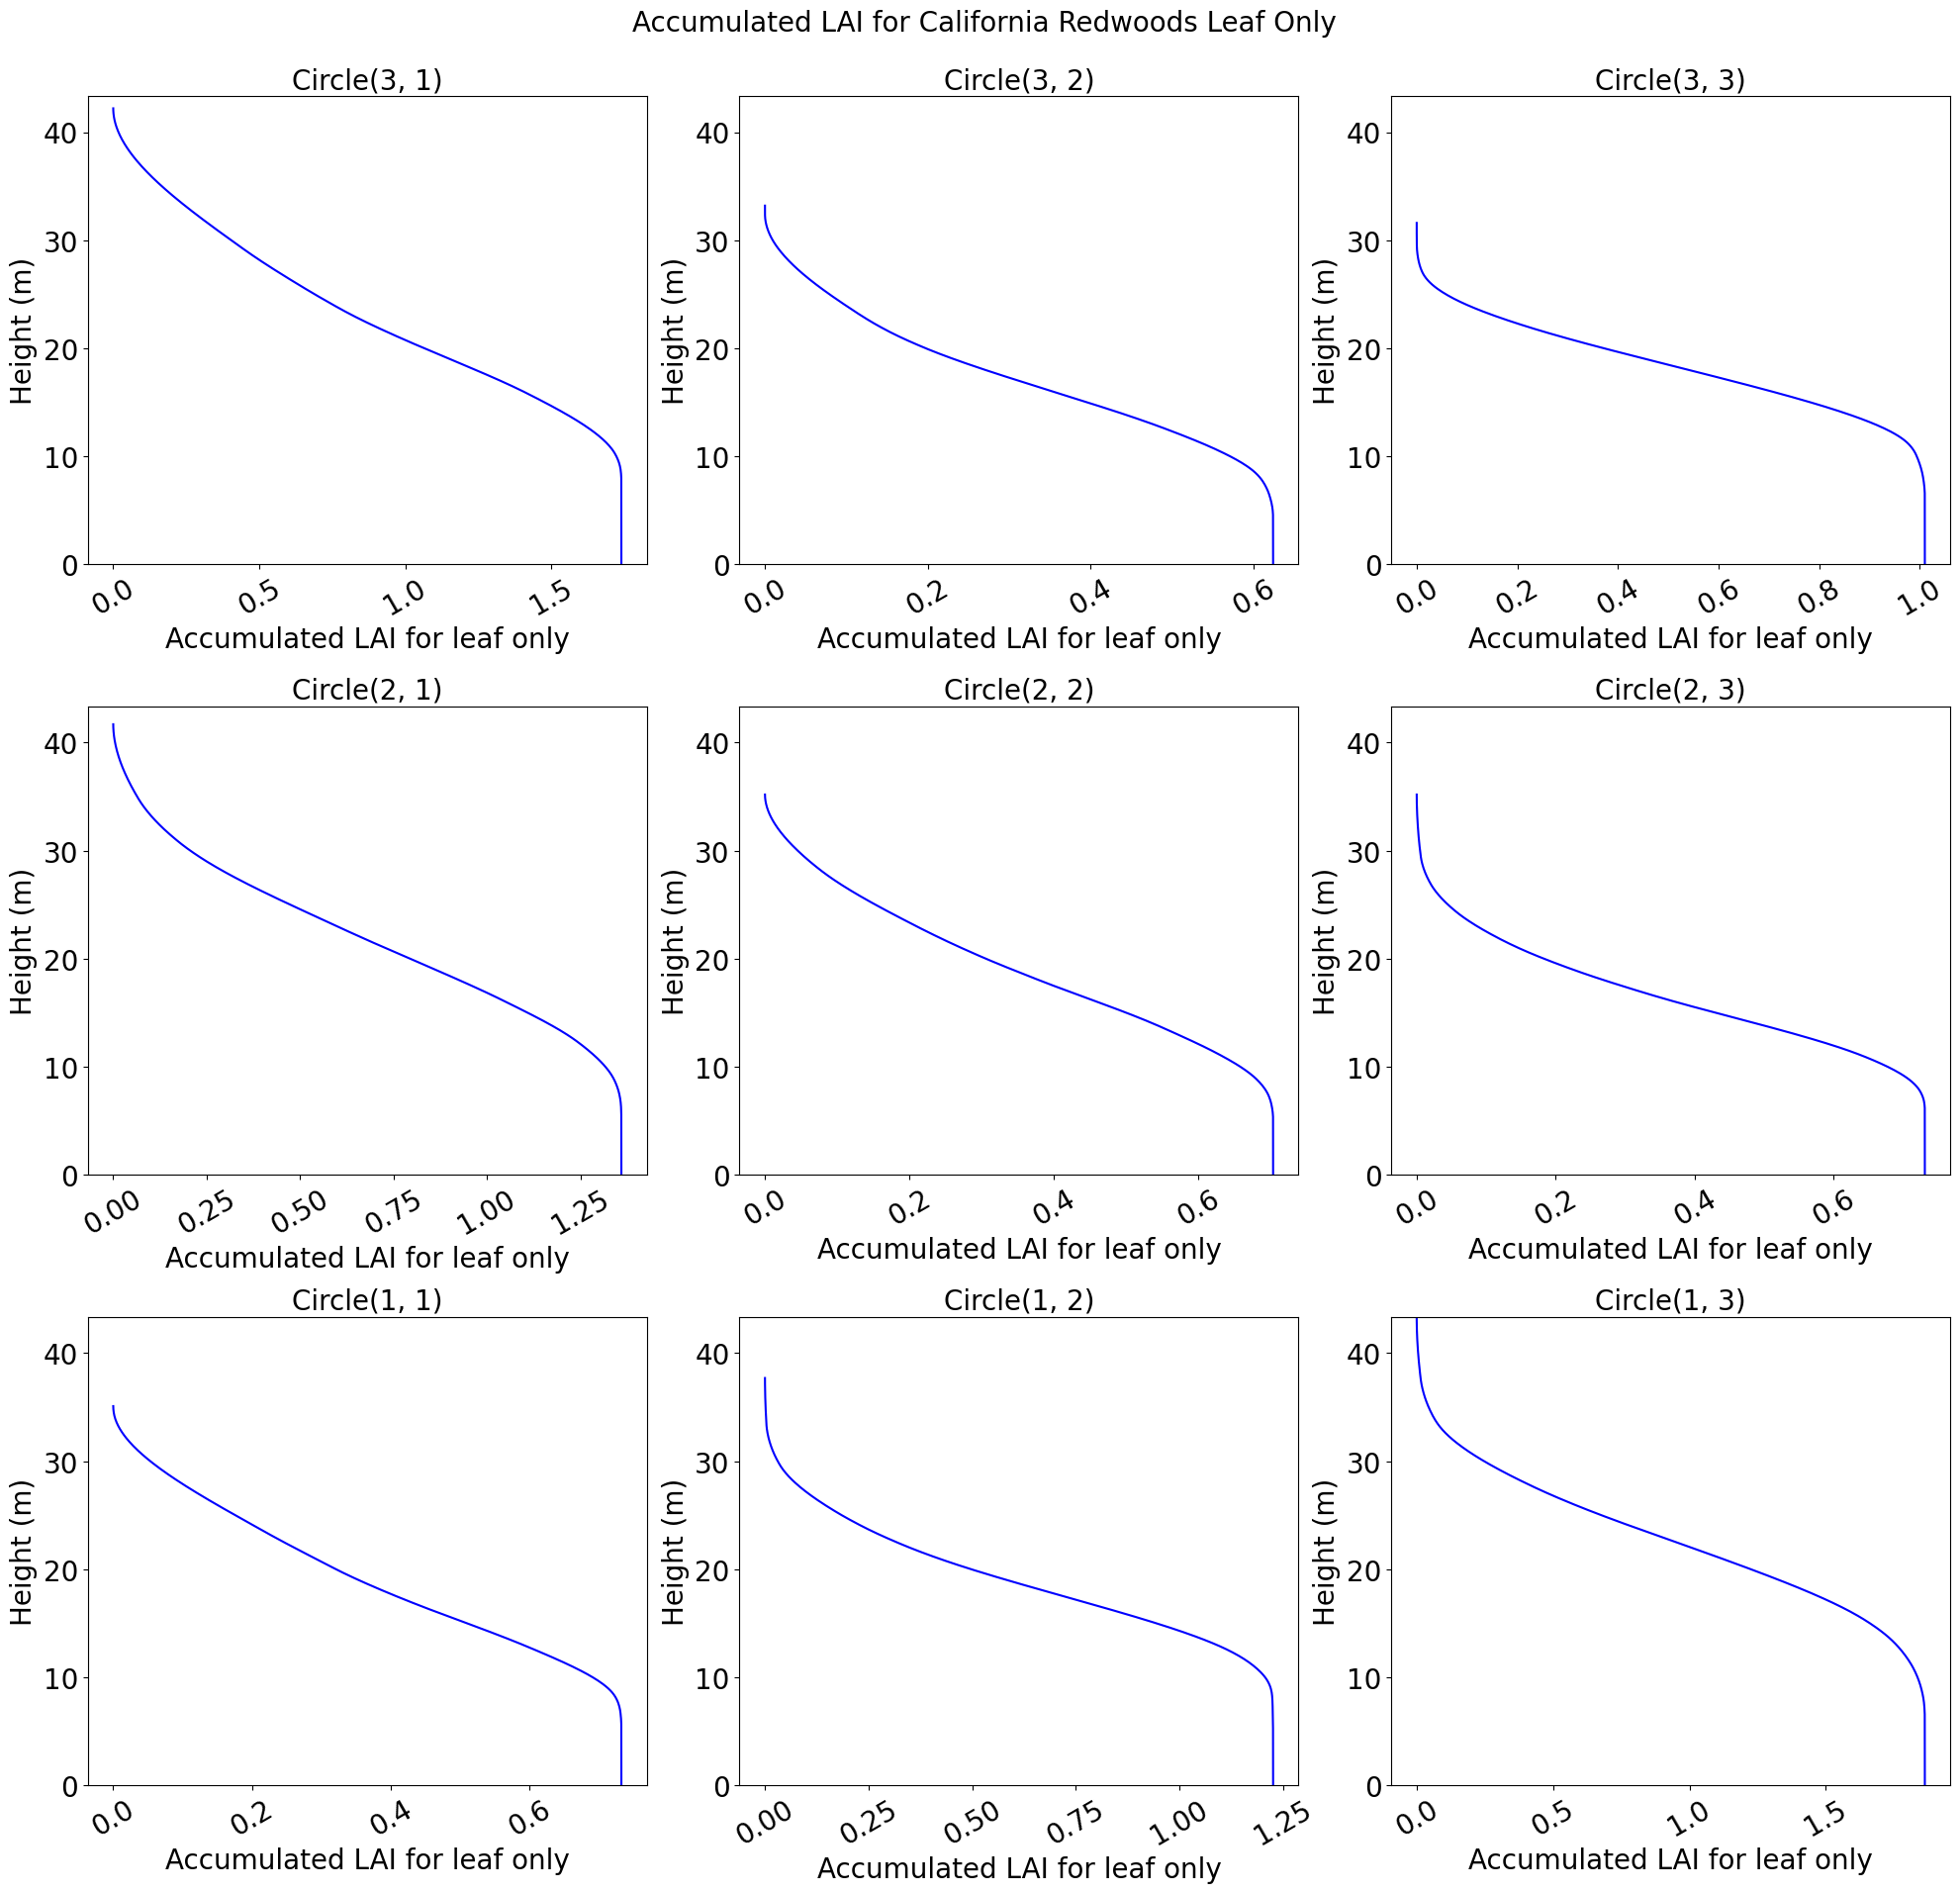

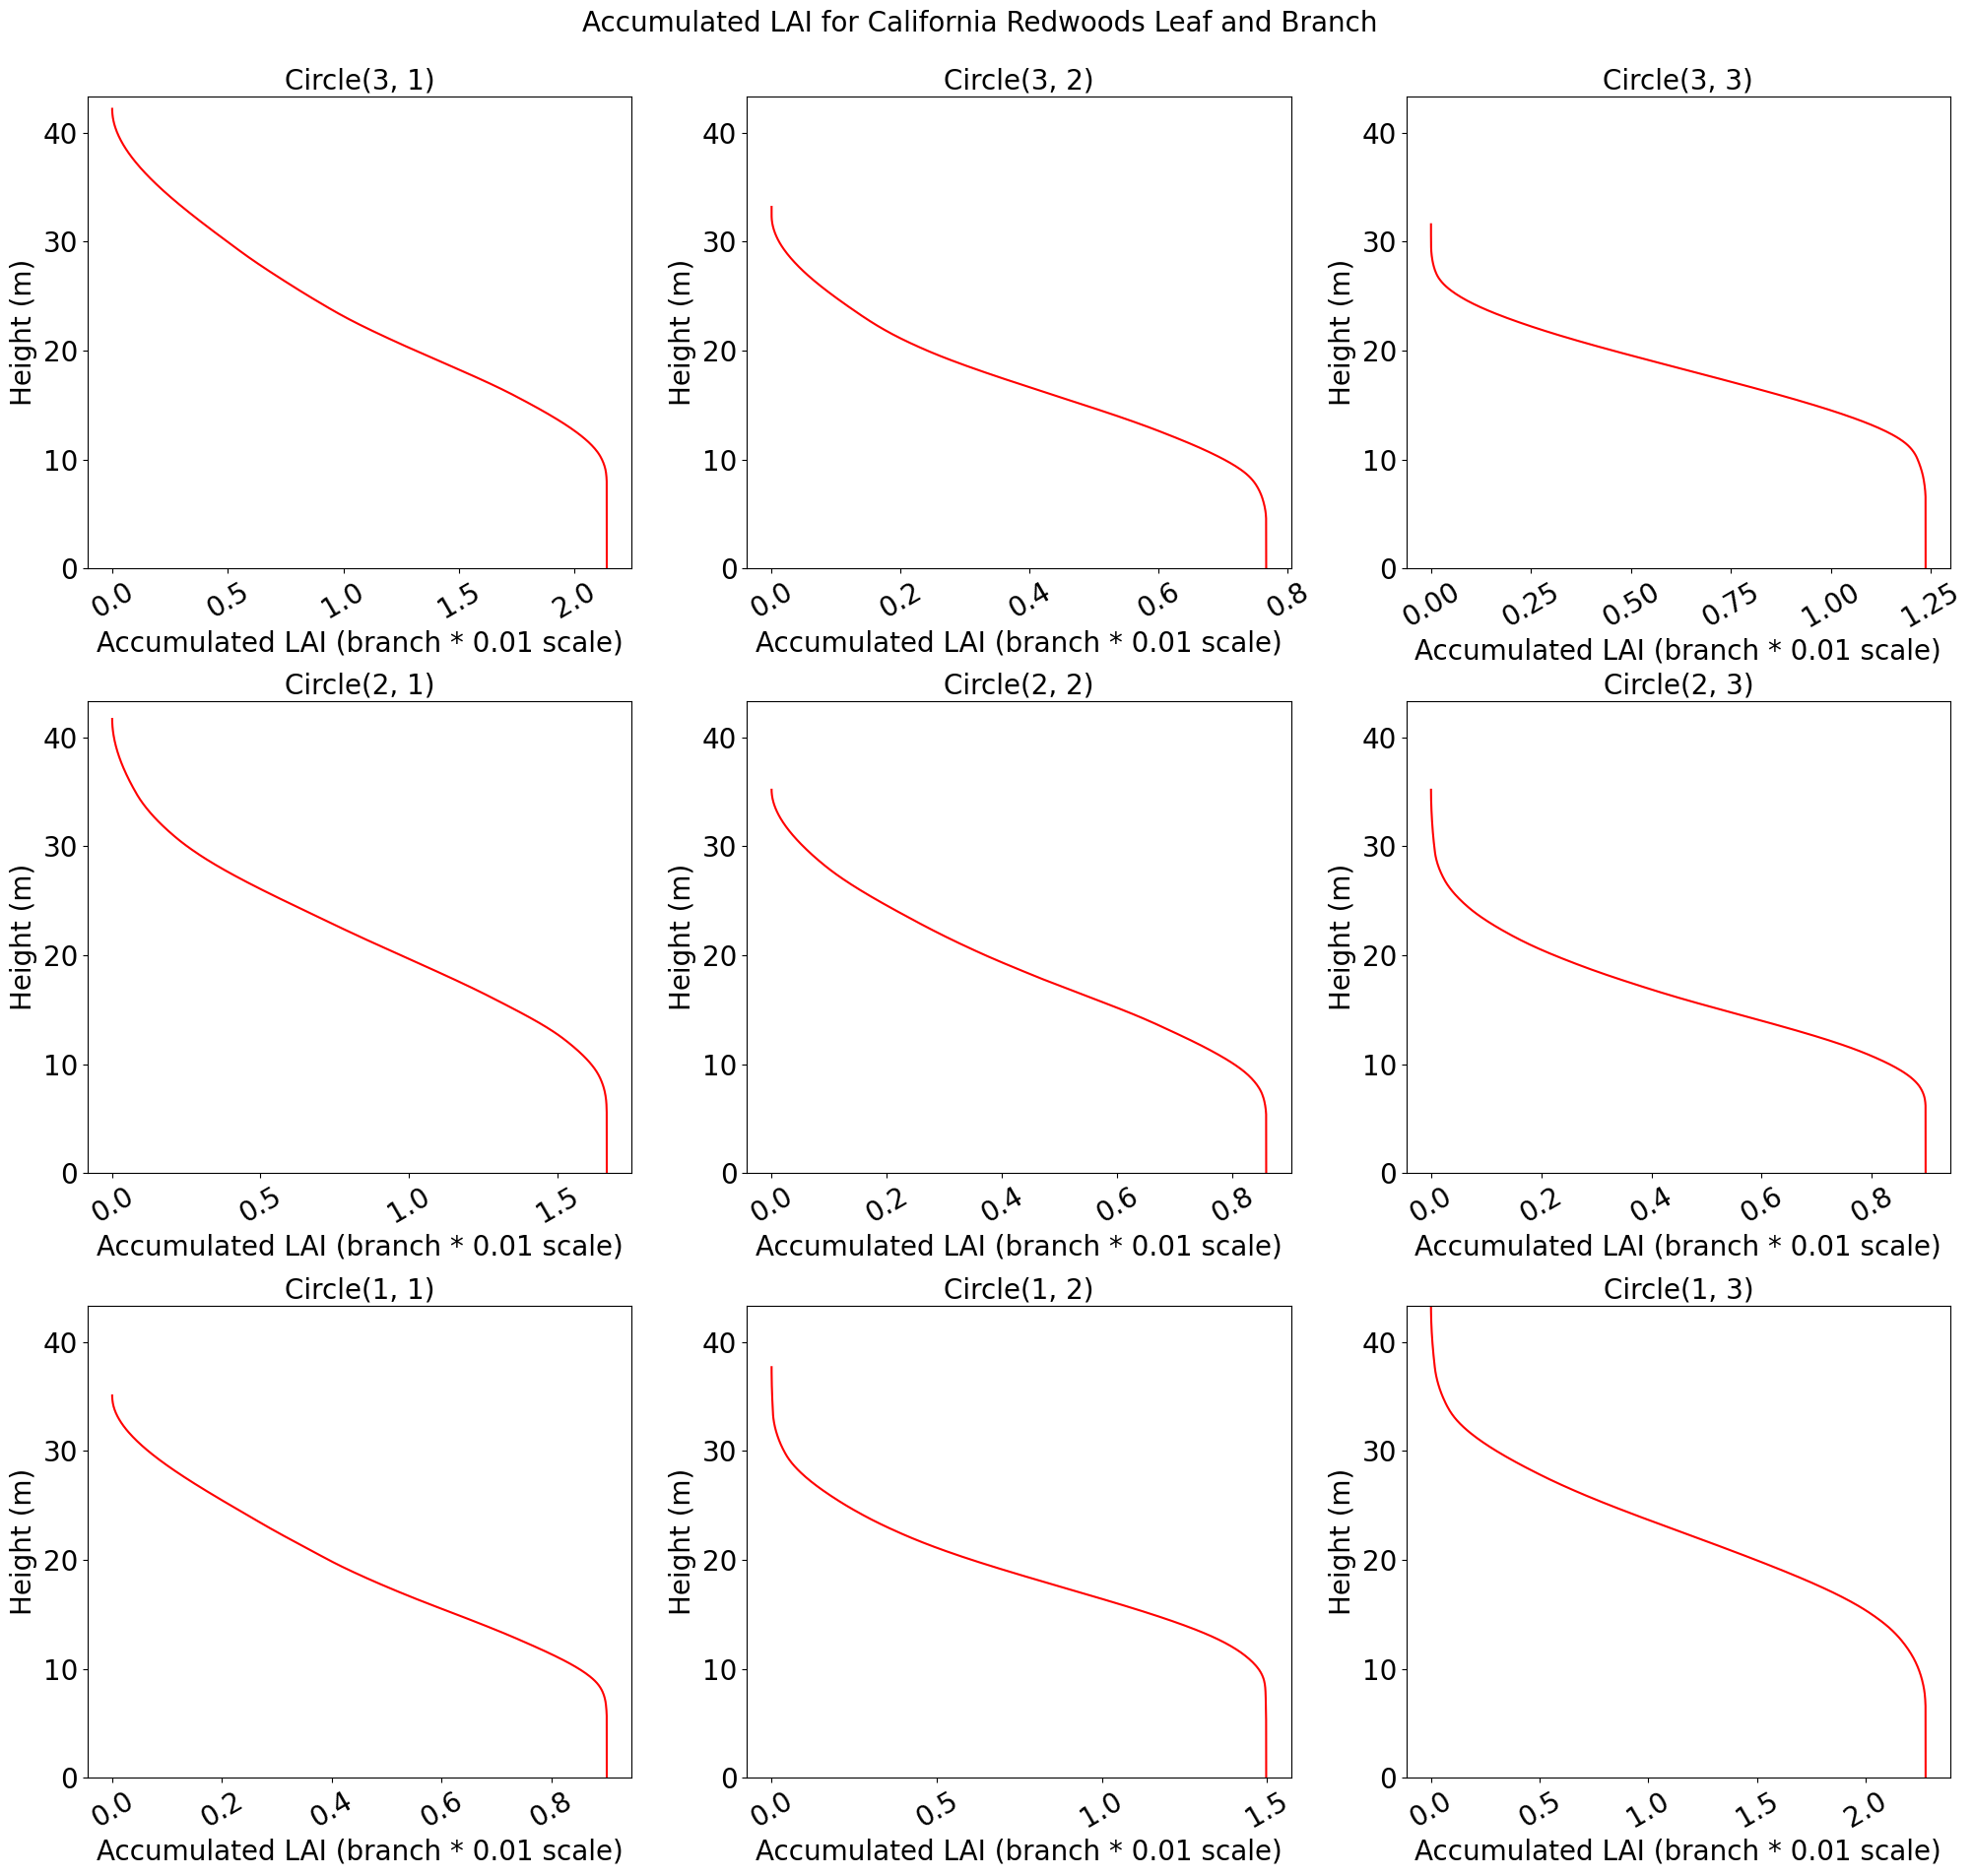

In [51]:
plot_circle_acc_LAI_with_subplots(redwood_circle_objects, section_range, 'leaf', 'Accumulated LAI for California Redwoods Leaf Only', output_path, 'redwood')

plot_circle_acc_LAI_with_subplots(redwood_circle_objects, section_range, 'veg', 'Accumulated LAI for California Redwoods Leaf and Branch', output_path, 'redwood')

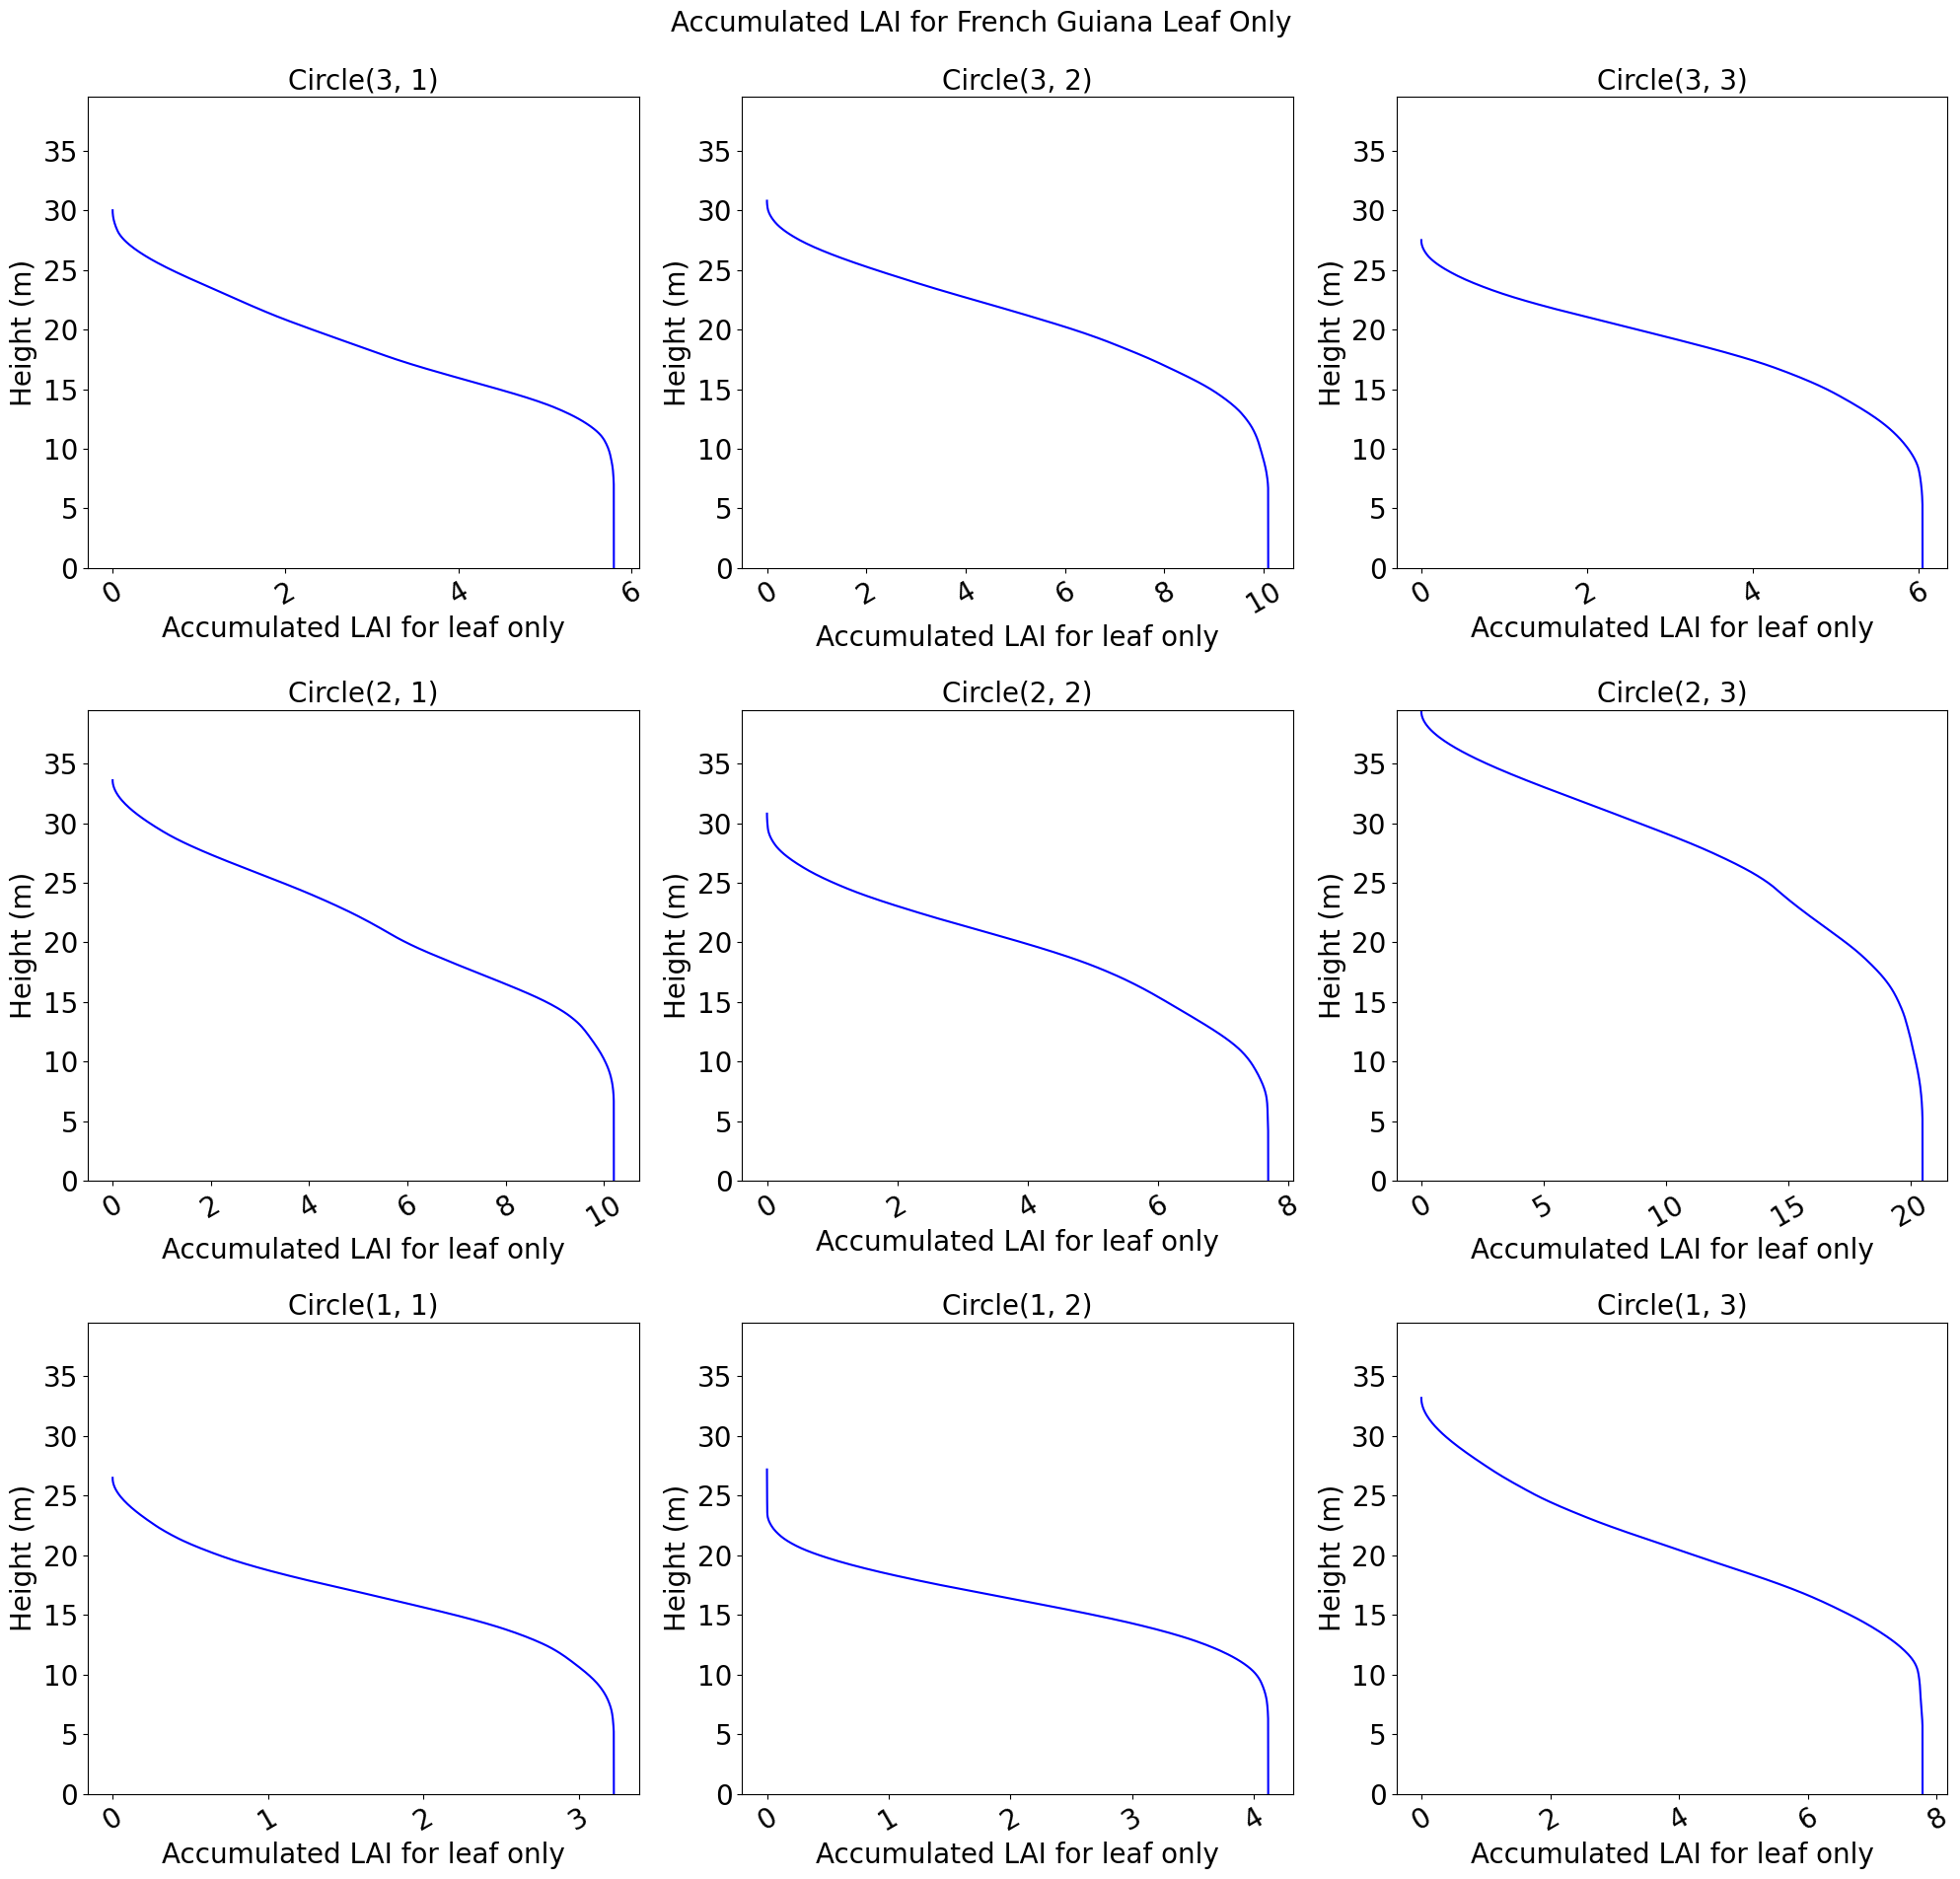

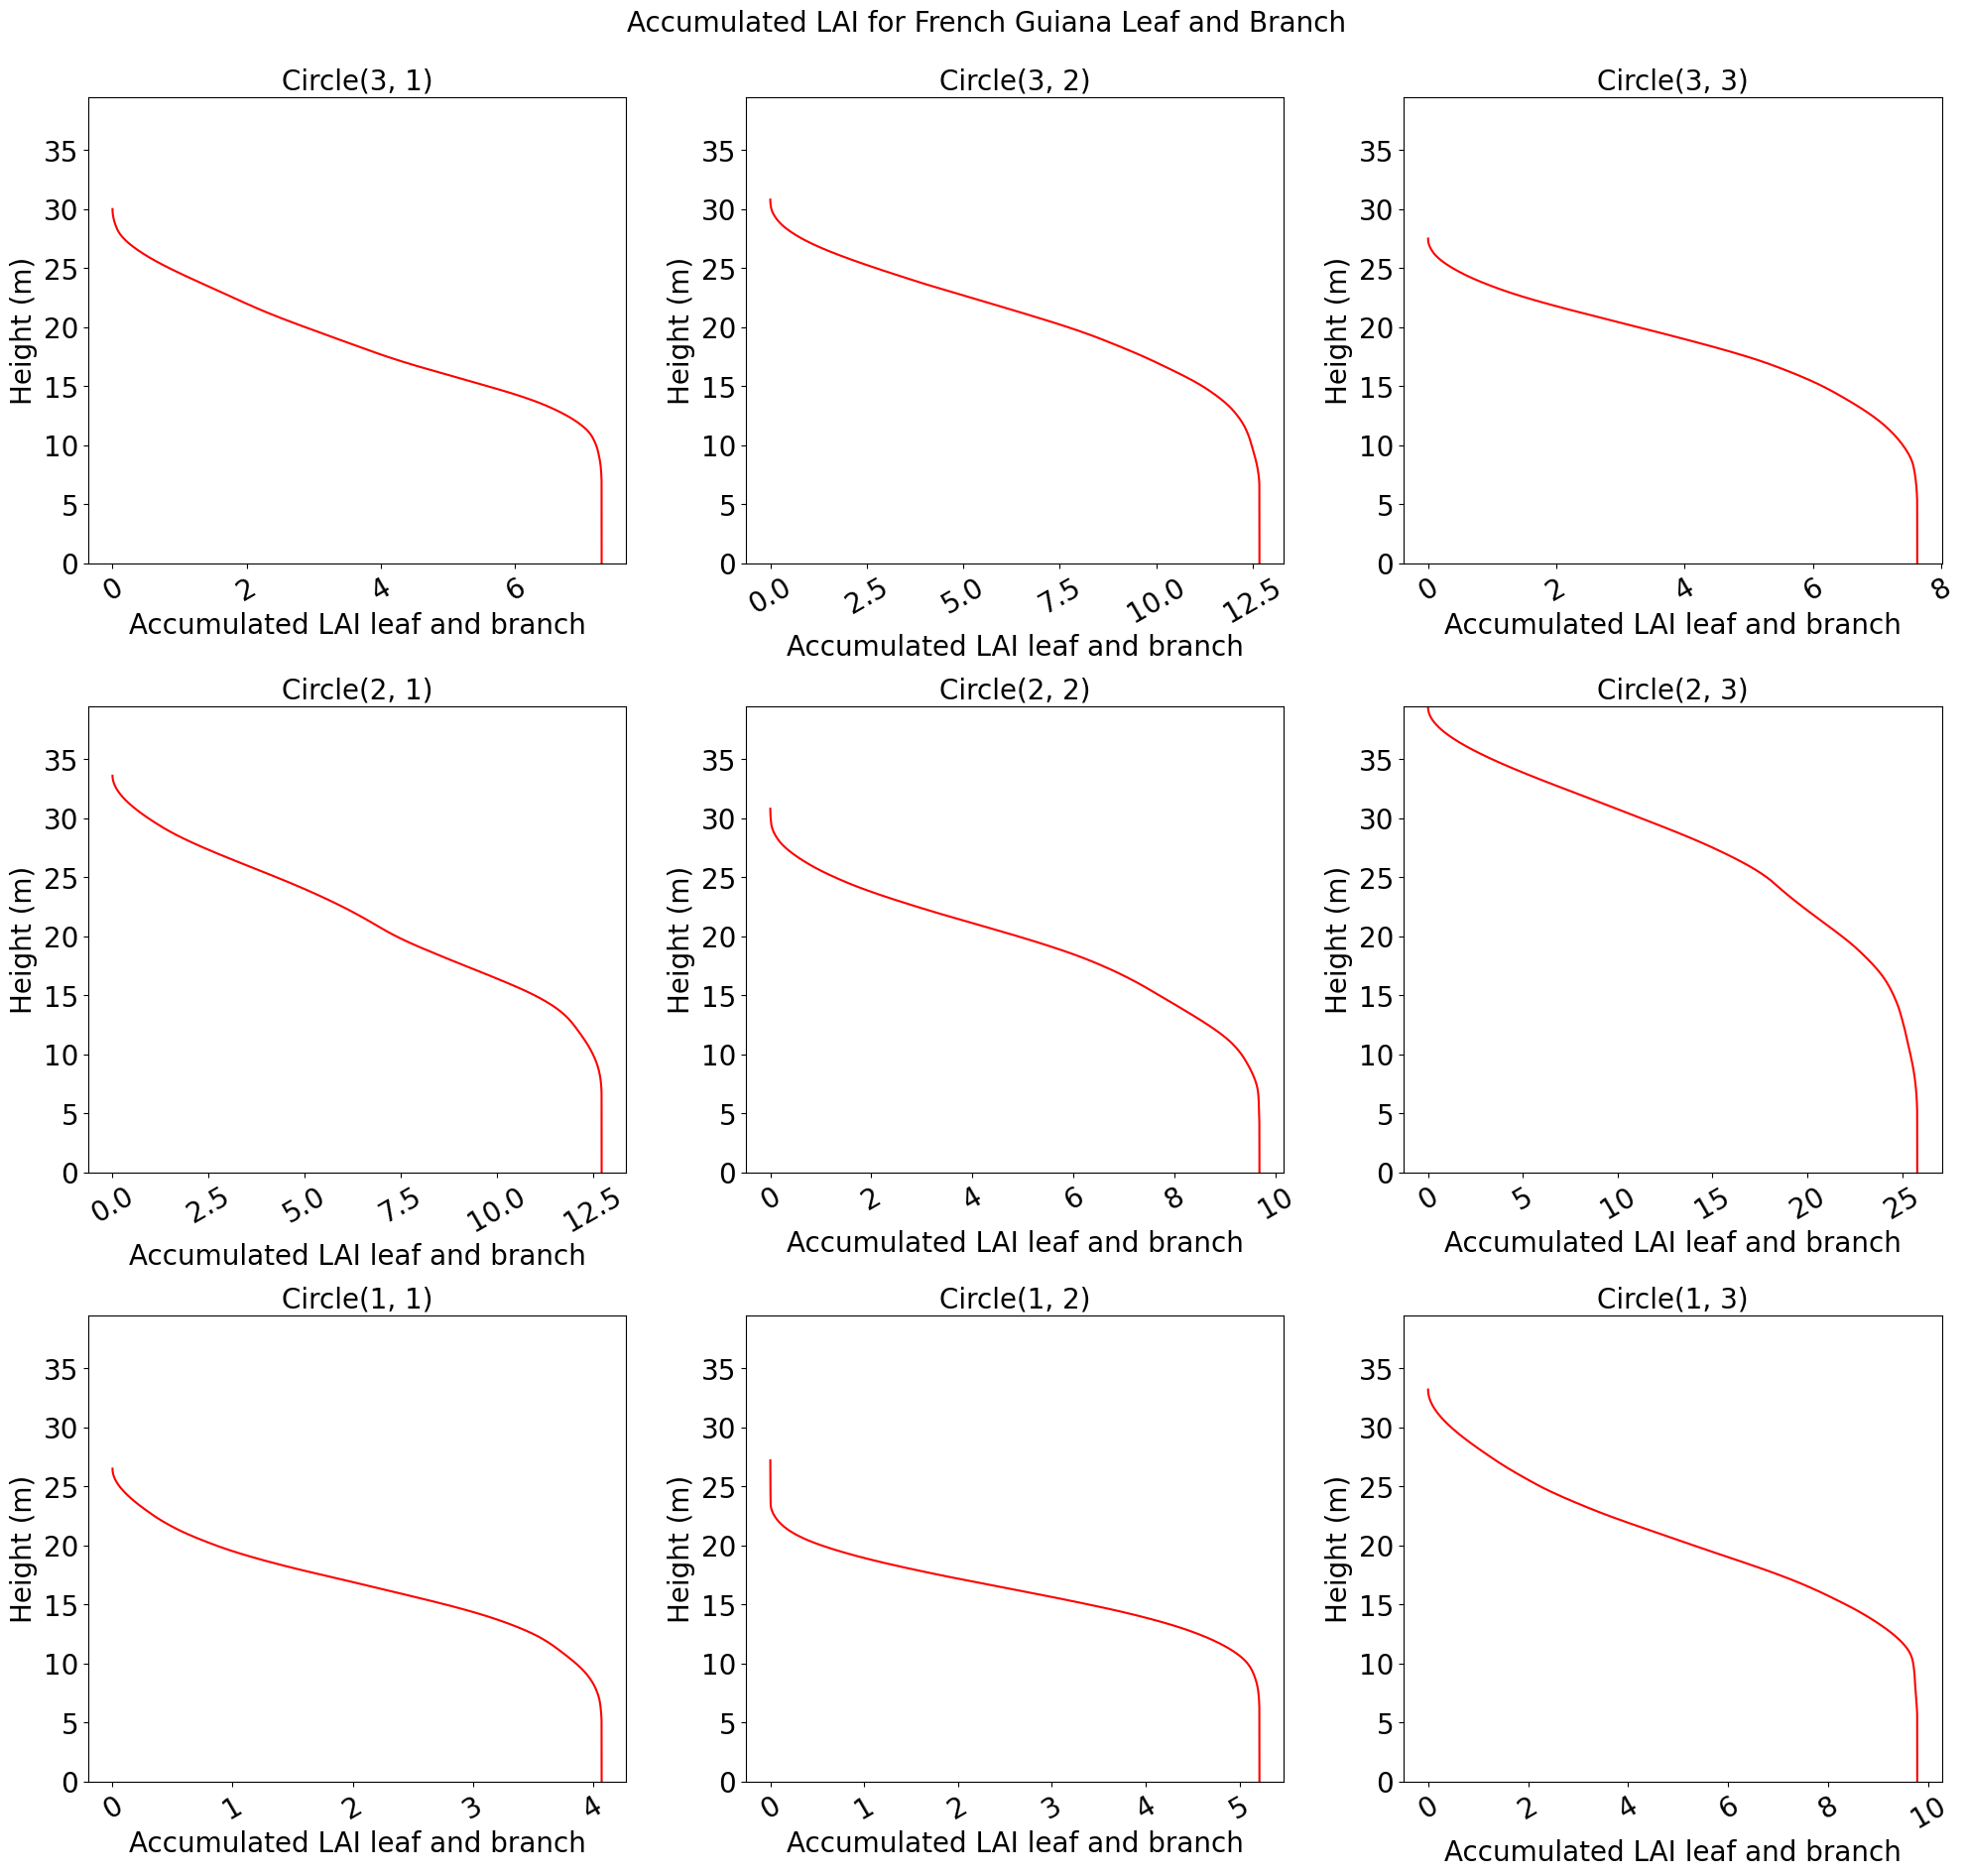

In [52]:
plot_circle_acc_LAI_with_subplots(guiana_circle_objects, section_range, 'leaf', 'Accumulated LAI for French Guiana Leaf Only', output_path, 'guiana')

plot_circle_acc_LAI_with_subplots(guiana_circle_objects, section_range, 'veg', 'Accumulated LAI for French Guiana Leaf and Branch', output_path, 'guiana')

In [53]:
import pandas as pd

# This function creates and returns a list of Circle objects and assigns their name
def create_circle_pgap_data():

    circles_grid = []

    # Check each circle in the 3x3 grid
    for i in range(3, 0, -1):
        for j in range(1, 4):
            
            # Create the circle object with a unique name
            circle_name = f"Circle({i}, {j})"
            circle = lidar_sim_class_declarations.Circle_pgap(circle_name)

            # Assign the row and columns to the circle
            circle.row = i
            circle.column = j

            # Append the circle to the grid list
            circles_grid.append(circle)

    return circles_grid

def calc_gap_prob(circle_objects, pgap_objects, type):

    df_list = []

    for circle in circle_objects:
        if (type == "leaf"):
            new_Fa = circle.total_Fa
        elif (type == "branch"):
            new_Fa = circle.total_Fa_b
        else:
            raise ValueError("Invalid type. Supported types are 'leaf' and 'branch'.")
    
        df = pd.DataFrame()
        meter_range = np.arange(1, len(new_Fa) + 1 * section_range)
        accumulated_Fa = np.cumsum(new_Fa[::-1])[::-1]
        gap_prob = np.exp(-accumulated_Fa / 2)

        df['Height z'] = meter_range
        df['Fa'] = new_Fa
        df['accFa'] = accumulated_Fa
        df['P'] = gap_prob
        df[''] = ''

        df_list.append(df)
    
    return df_list

def output_saveCSV(sitename, df_list, path):
    combined_df = pd.DataFrame()

    for df in df_list:
        print()

        df['Fa'] = df['Fa'].map('{:.9f}'.format)
        df['accFa'] = df['accFa'].map('{:.9f}'.format)
        df['P'] = df['P'].map('{:.30f}'.format)

        reversed_df = df.iloc[::-1].reset_index(drop=True)
        combined_df = pd.concat([combined_df, reversed_df], axis=1)

        pd.set_option('display.expand_frame_repr', False)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(reversed_df[['Height z', 'Fa', 'accFa', 'P']])

    pgap_path = path + "gap_probability/"

    if not os.path.exists(pgap_path):
        os.makedirs(pgap_path)

    combined_df.to_csv(f'{pgap_path}{sitename}_foliage_profile.csv', index=False)

import matplotlib.pyplot as plt

def plot_gap_probability(df_list, sitename, circle_names, path):
    num_rows = 3
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 24))

    # Determine line color based on sitename
    if "leaf" in sitename.lower():
        line_color = 'blue'
    elif "veg" in sitename.lower():
        line_color = 'red'

    for i, (df, circle_name) in enumerate(zip(df_list, circle_names)):
        row = i // num_cols
        col = i % num_cols

        ax = axs[row, col]
        ax.plot(df['P'].astype(float), df['Height z'].astype(float) * section_range, color=line_color)
        ax.set_xlabel('Total Gap Probability (P)')
        ax.set_ylabel('Height z')
        ax.set_title(circle_name)
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    plt.suptitle(f'Total Gap Probability vs Height for {sitename}', fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust the top parameter here

    # Save the figure to a PNG file
    pgap_path = path + "gap_probability/"

    if not os.path.exists(pgap_path):
        os.makedirs(pgap_path)

    plt.savefig(f'{pgap_path}{sitename}_gap_probability.png', bbox_inches='tight')
    plt.show()

In [54]:
redwood_circle_pgap_objects = create_circle_pgap_data()
guiana_circle_pgap_objects = create_circle_pgap_data()
redwood_leaf_pgap_df_list = calc_gap_prob(redwood_circle_objects, redwood_circle_pgap_objects, "leaf")
redwood_branch_pgap_df_list = calc_gap_prob(redwood_circle_objects, redwood_circle_pgap_objects, "branch")
guiana_leaf_pgap_df_list = calc_gap_prob(guiana_circle_objects, guiana_circle_pgap_objects, "leaf")
guiana_branch_pgap_df_list = calc_gap_prob(guiana_circle_objects, guiana_circle_pgap_objects, "branch")

for df in redwood_leaf_pgap_df_list:
    print(df)
output_saveCSV("redwood_leaf", redwood_leaf_pgap_df_list, output_path)
output_saveCSV("redwood_veg", redwood_branch_pgap_df_list, output_path)
output_saveCSV("guiana_leaf", guiana_leaf_pgap_df_list, output_path)
output_saveCSV("guiana_veg", guiana_branch_pgap_df_list, output_path)

     Height z        Fa     accFa         P   
0         1.0  0.000000  0.430924  0.806169   
1         2.0  0.000000  0.430924  0.806169   
2         3.0  0.000000  0.430924  0.806169   
3         4.0  0.000000  0.430924  0.806169   
4         5.0  0.000000  0.430924  0.806169   
..        ...       ...       ...       ... ..
418     419.0  0.000172  0.000517  0.999742   
419     420.0  0.000172  0.000344  0.999828   
420     421.0  0.000172  0.000172  0.999914   
421     422.0  0.000000  0.000000  1.000000   
422     423.0  0.000000  0.000000  1.000000   

[423 rows x 5 columns]
     Height z        Fa     accFa         P   
0         1.0  0.000000  0.394066  0.821164   
1         2.0  0.000000  0.394066  0.821164   
2         3.0  0.000000  0.394066  0.821164   
3         4.0  0.000000  0.394066  0.821164   
4         5.0  0.000000  0.394066  0.821164   
..        ...       ...       ...       ... ..
328     329.0  0.000172  0.000517  0.999742   
329     330.0  0.000172  0.000344  0

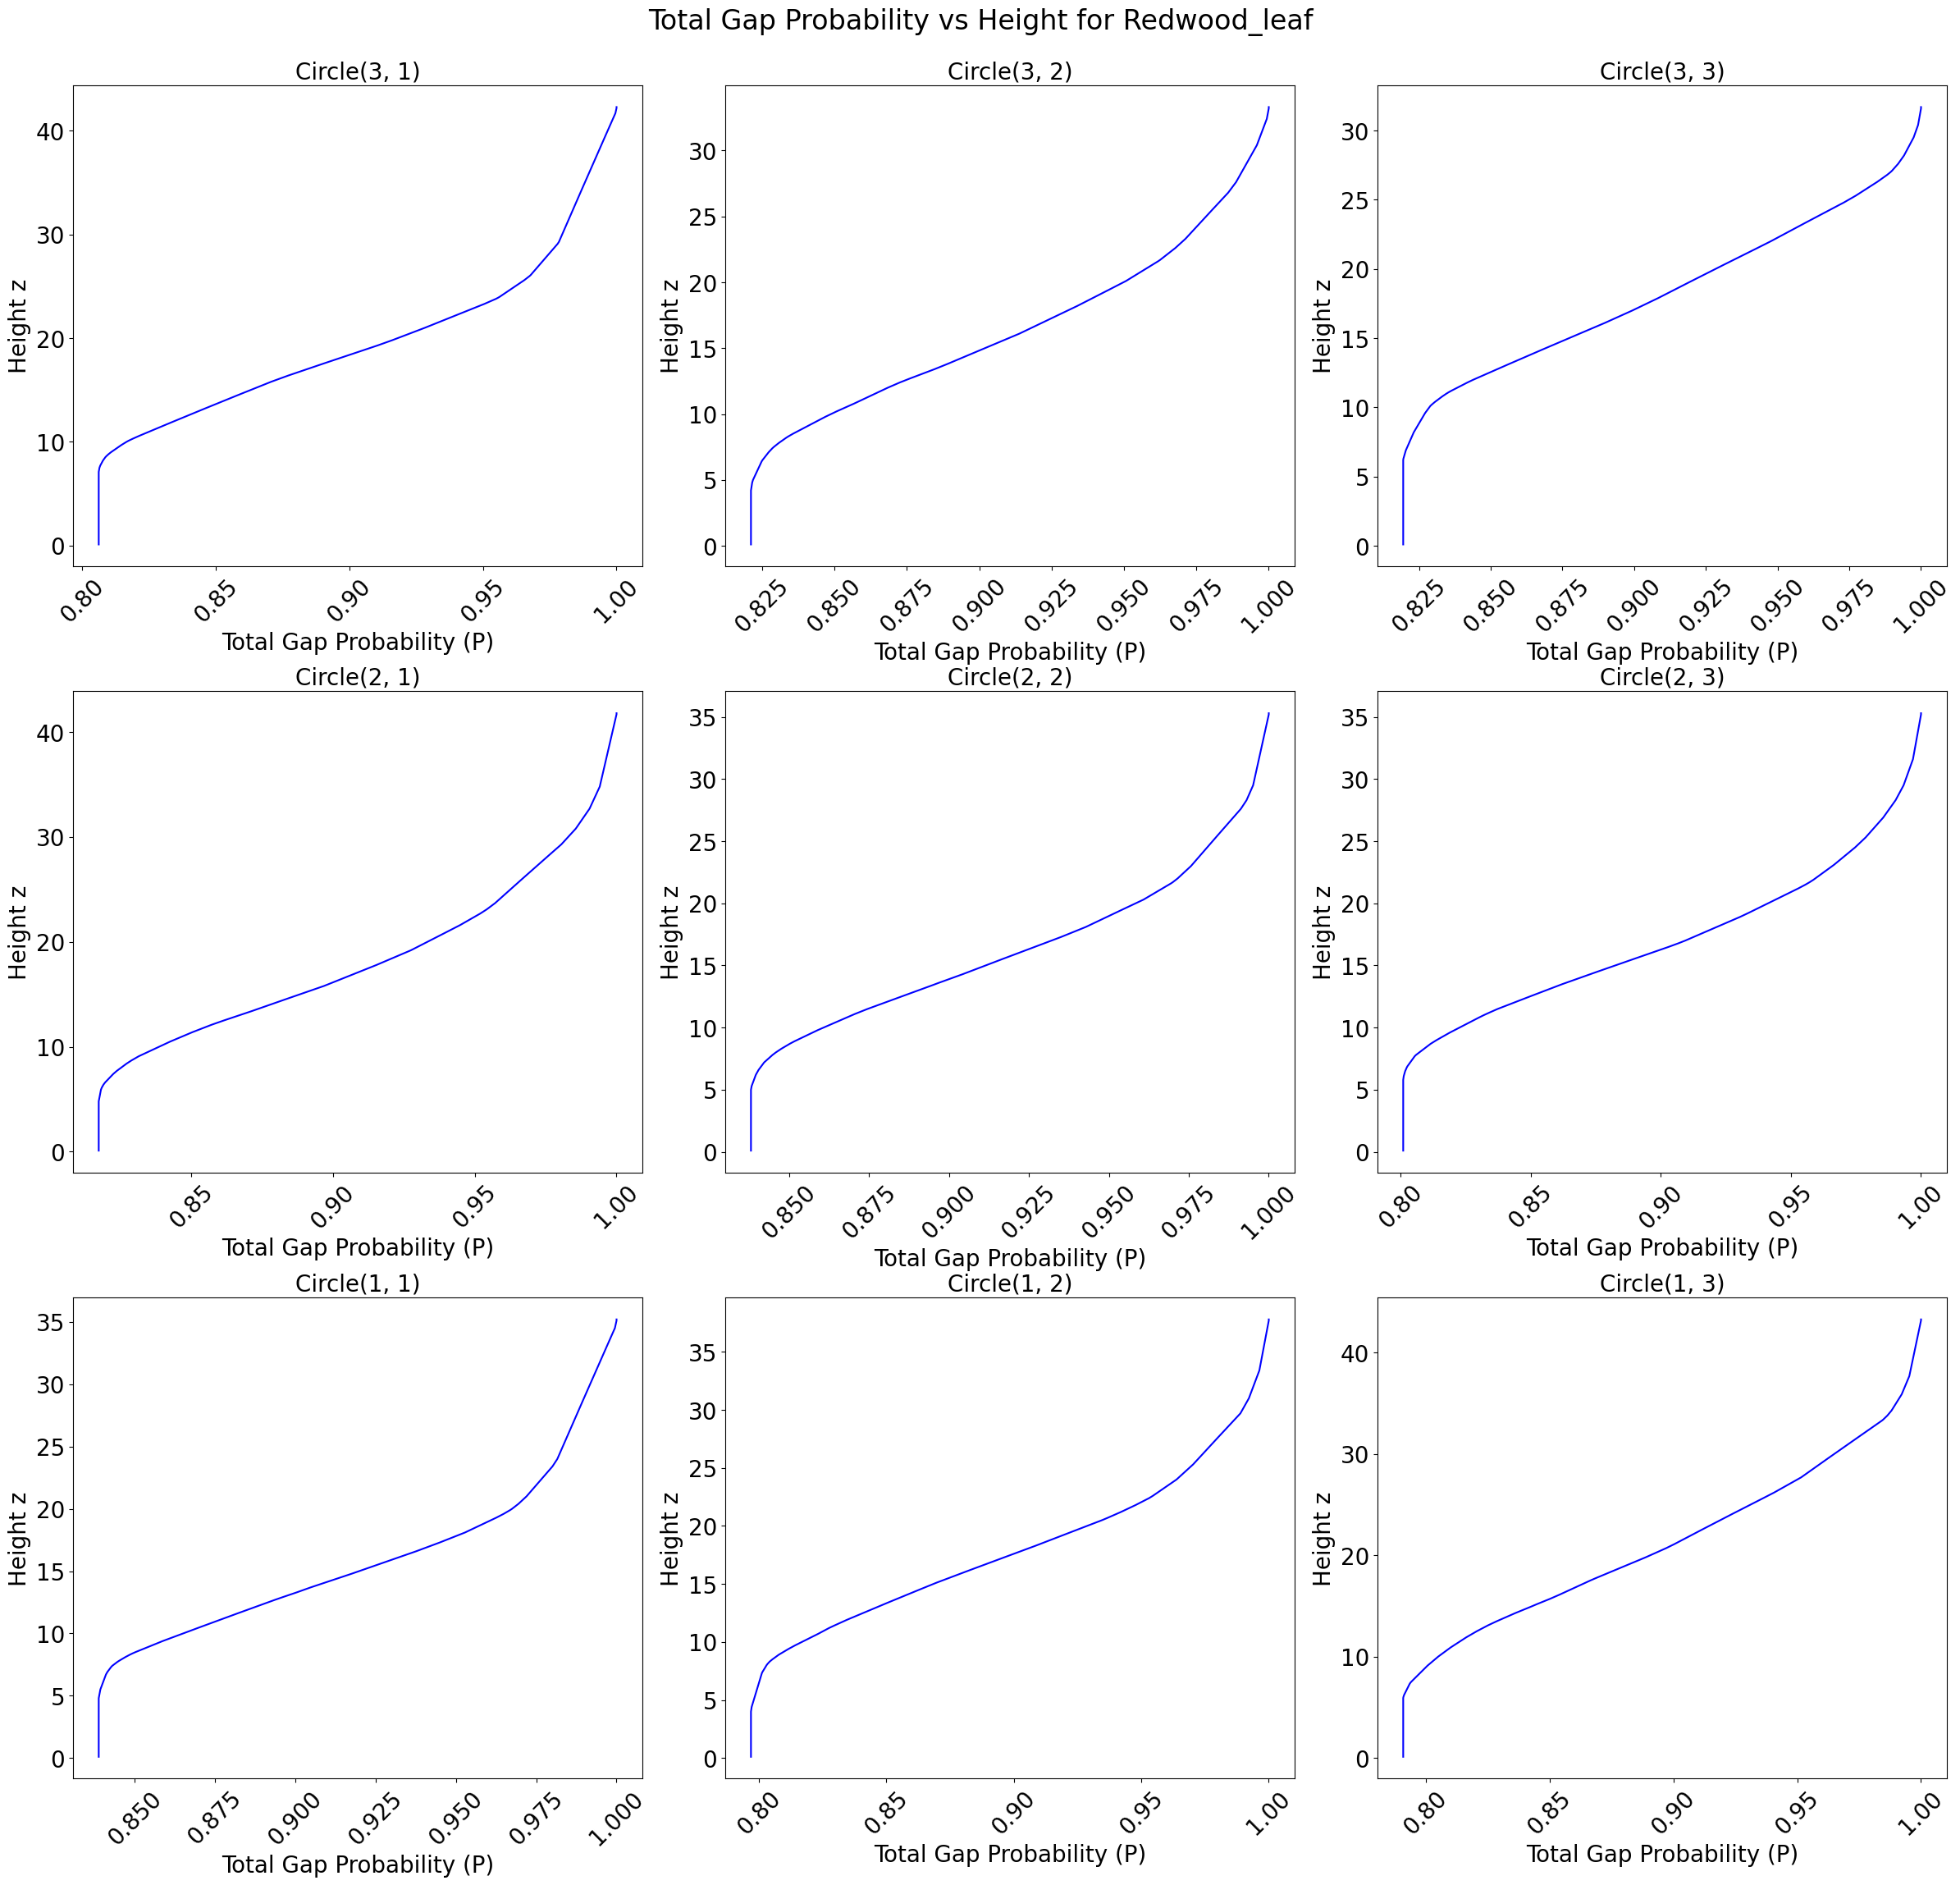

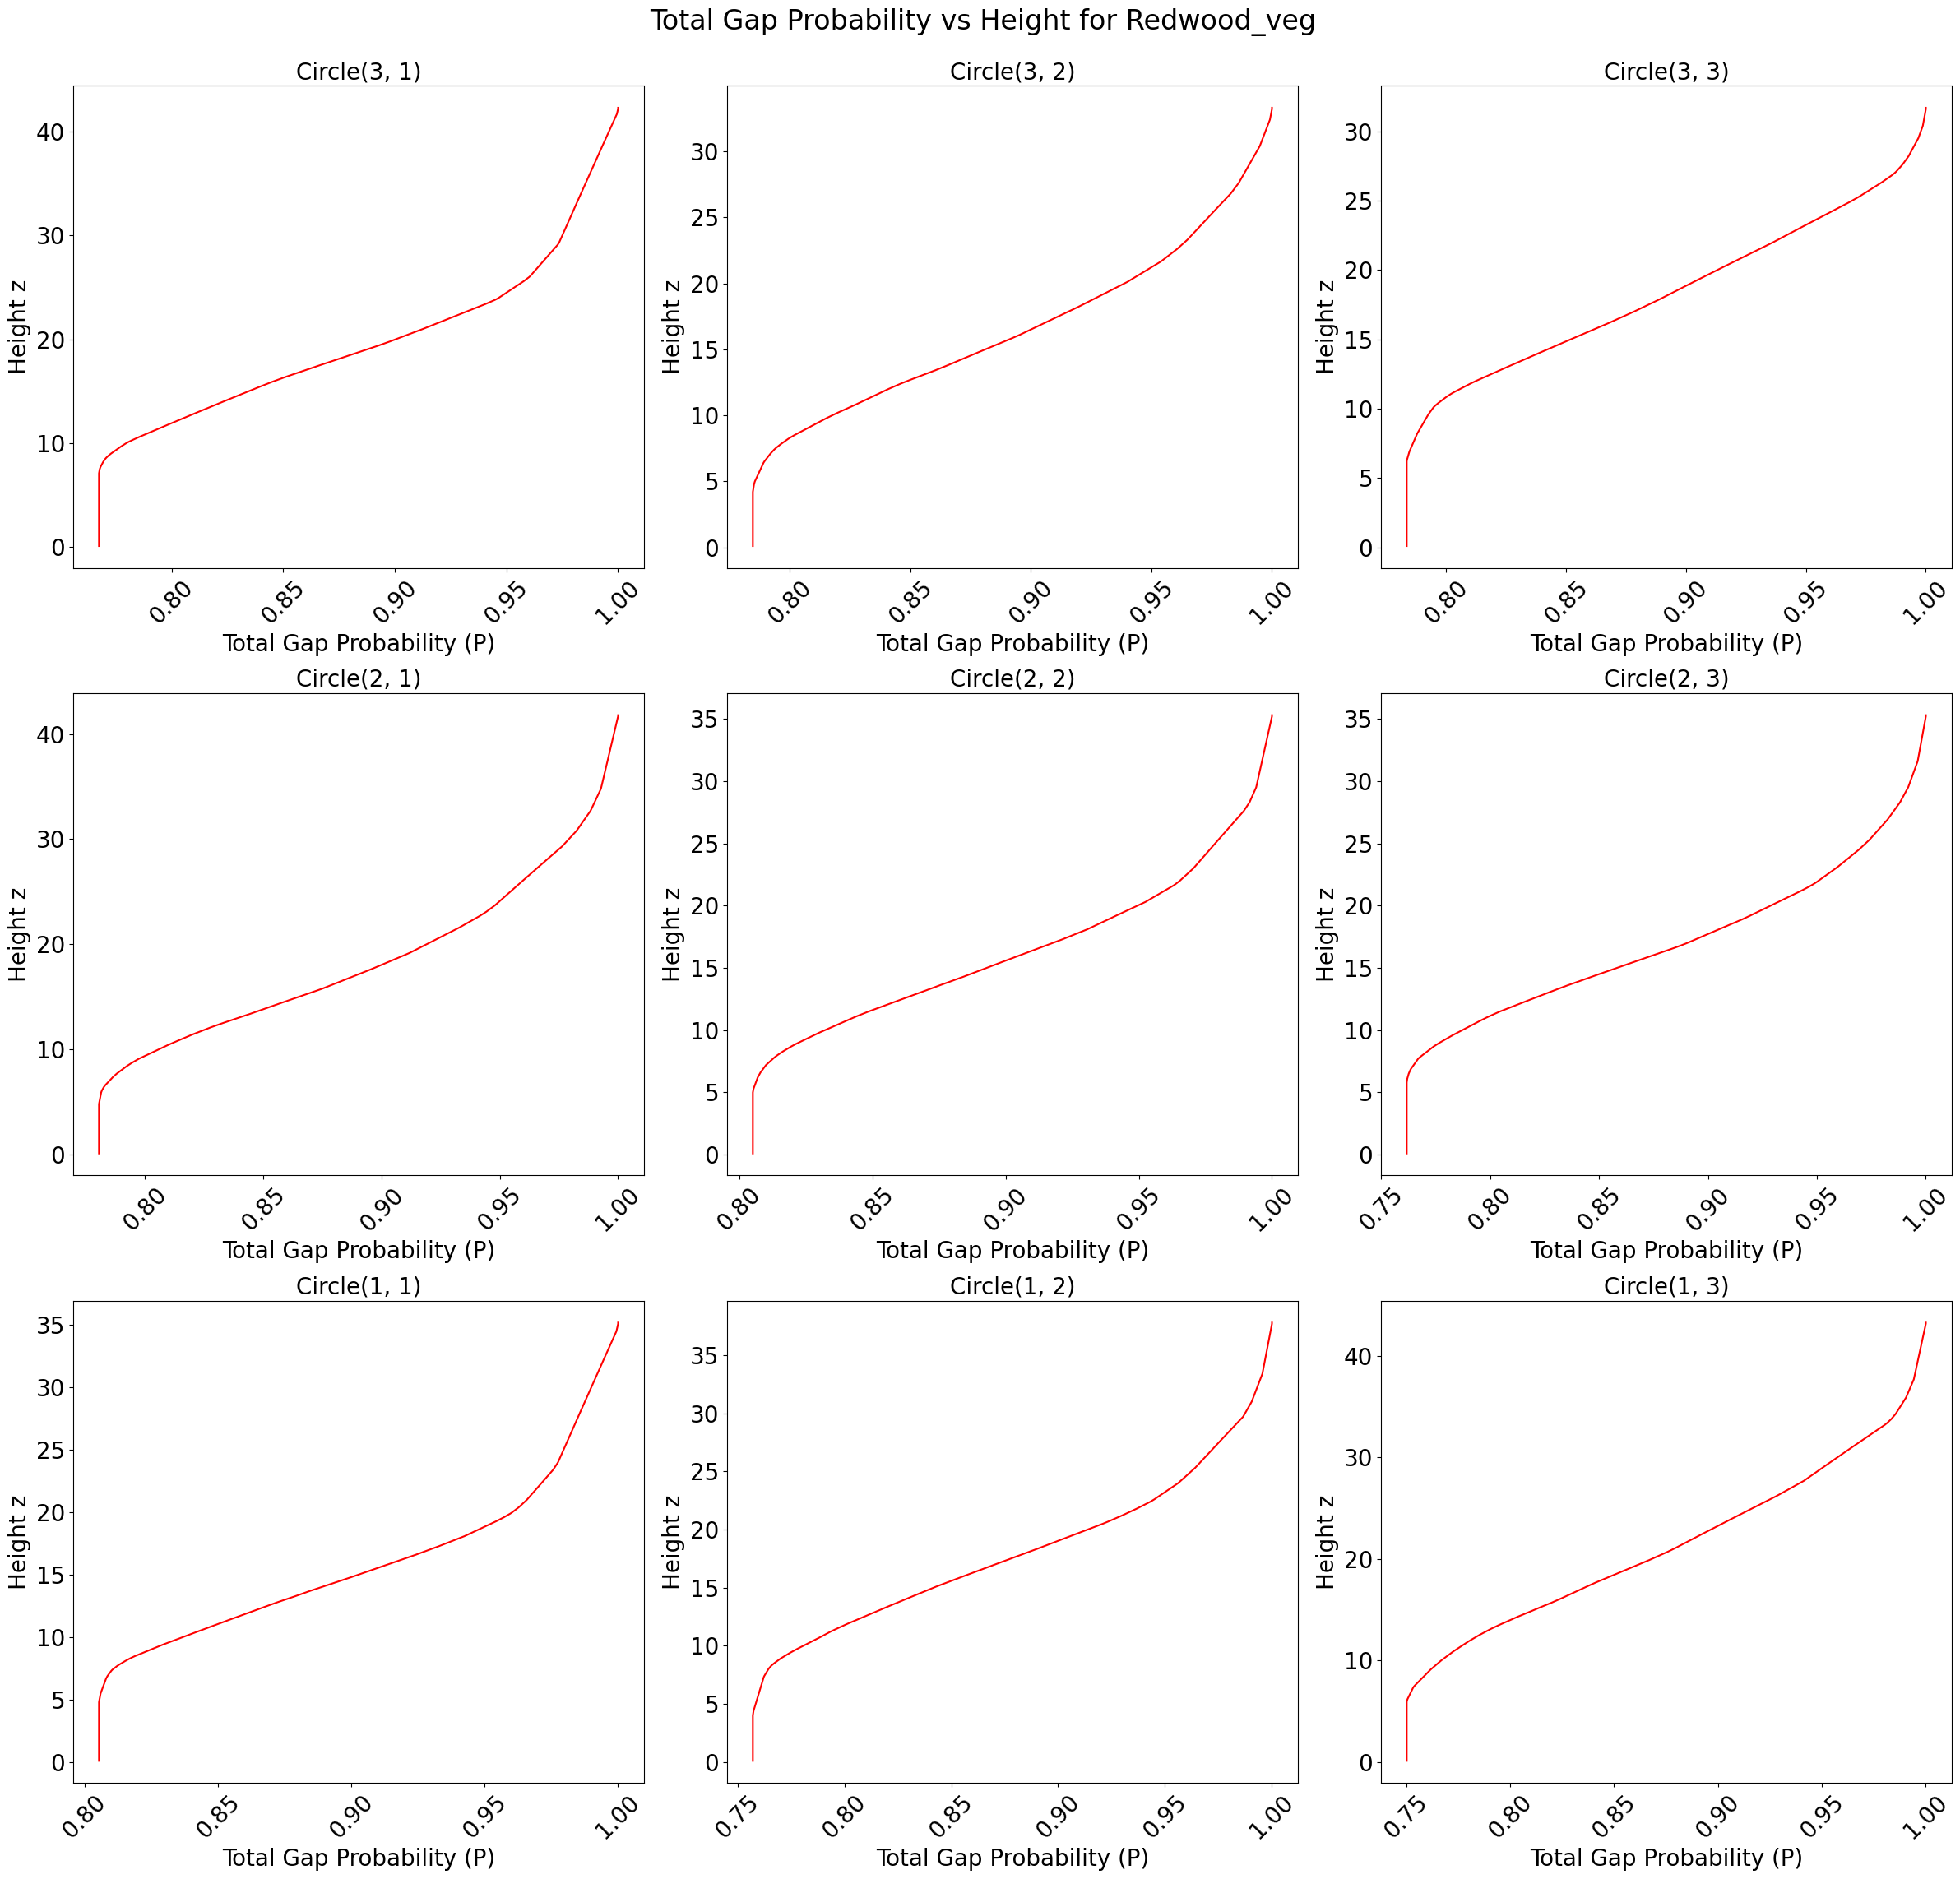

In [55]:
circle_names = [circle.circle_name for circle in redwood_circle_objects]
plot_gap_probability(redwood_leaf_pgap_df_list, "Redwood_leaf", circle_names, output_path)
plot_gap_probability(redwood_branch_pgap_df_list, "Redwood_veg", circle_names, output_path)

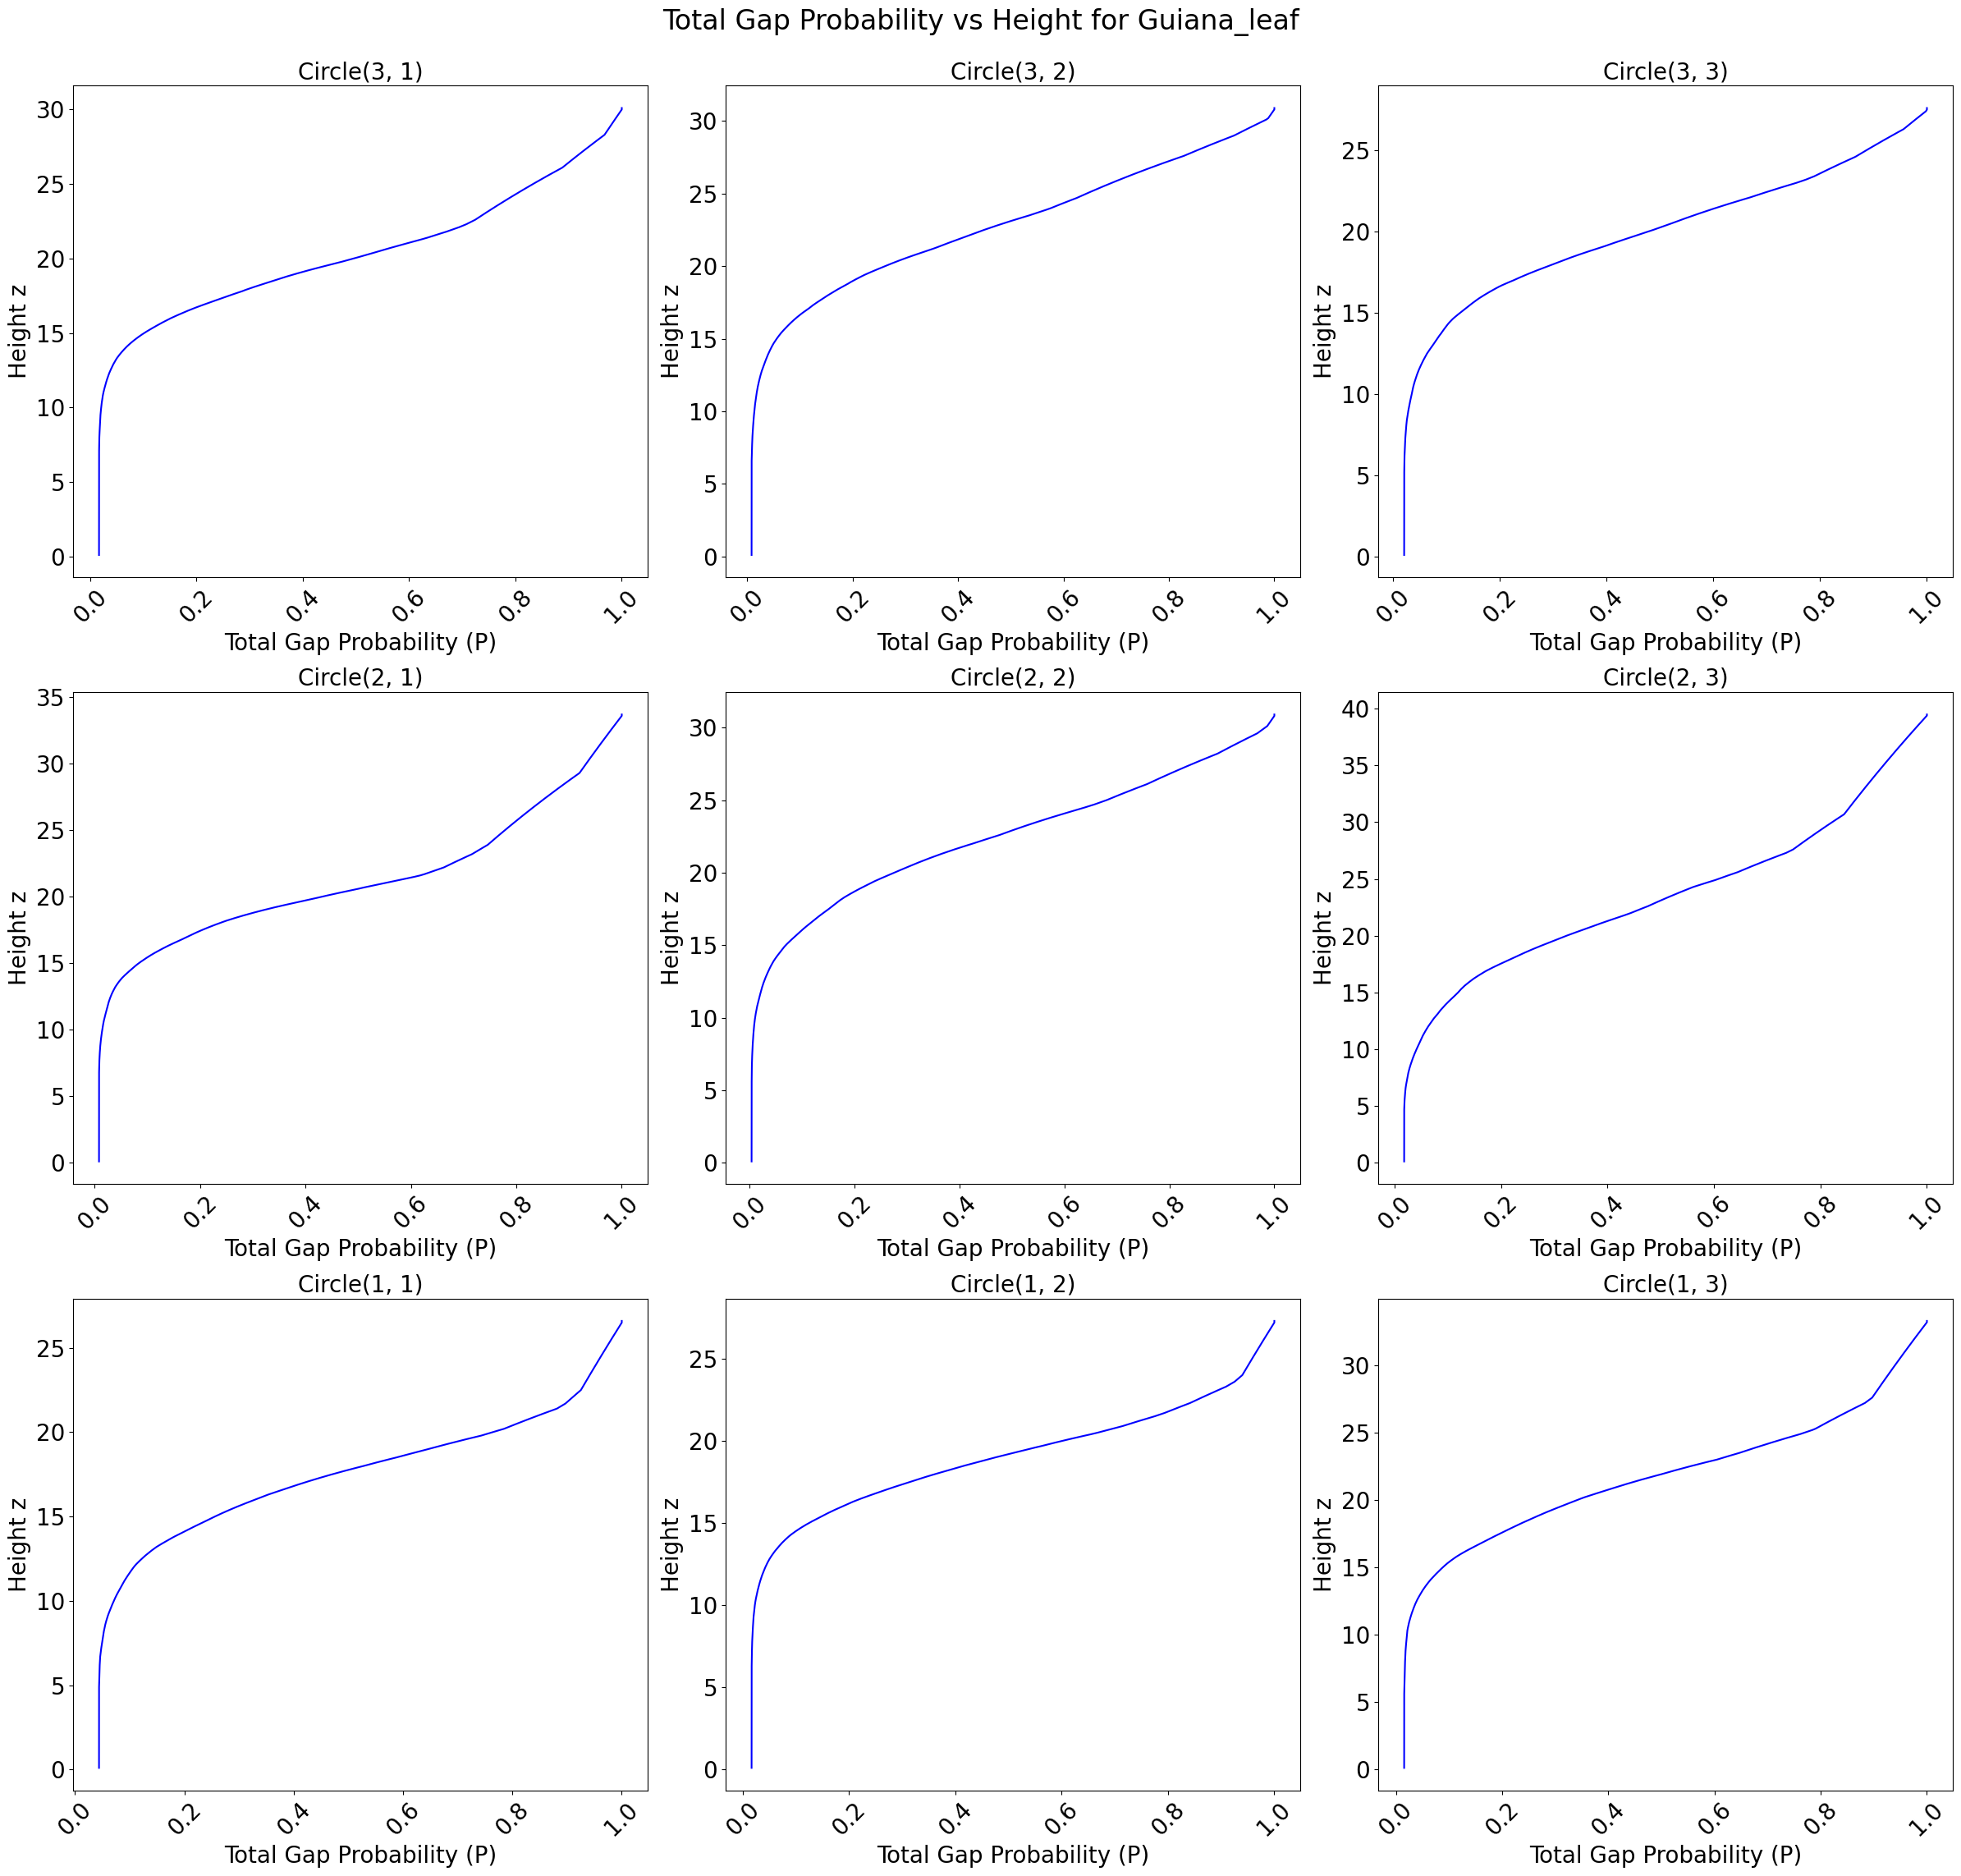

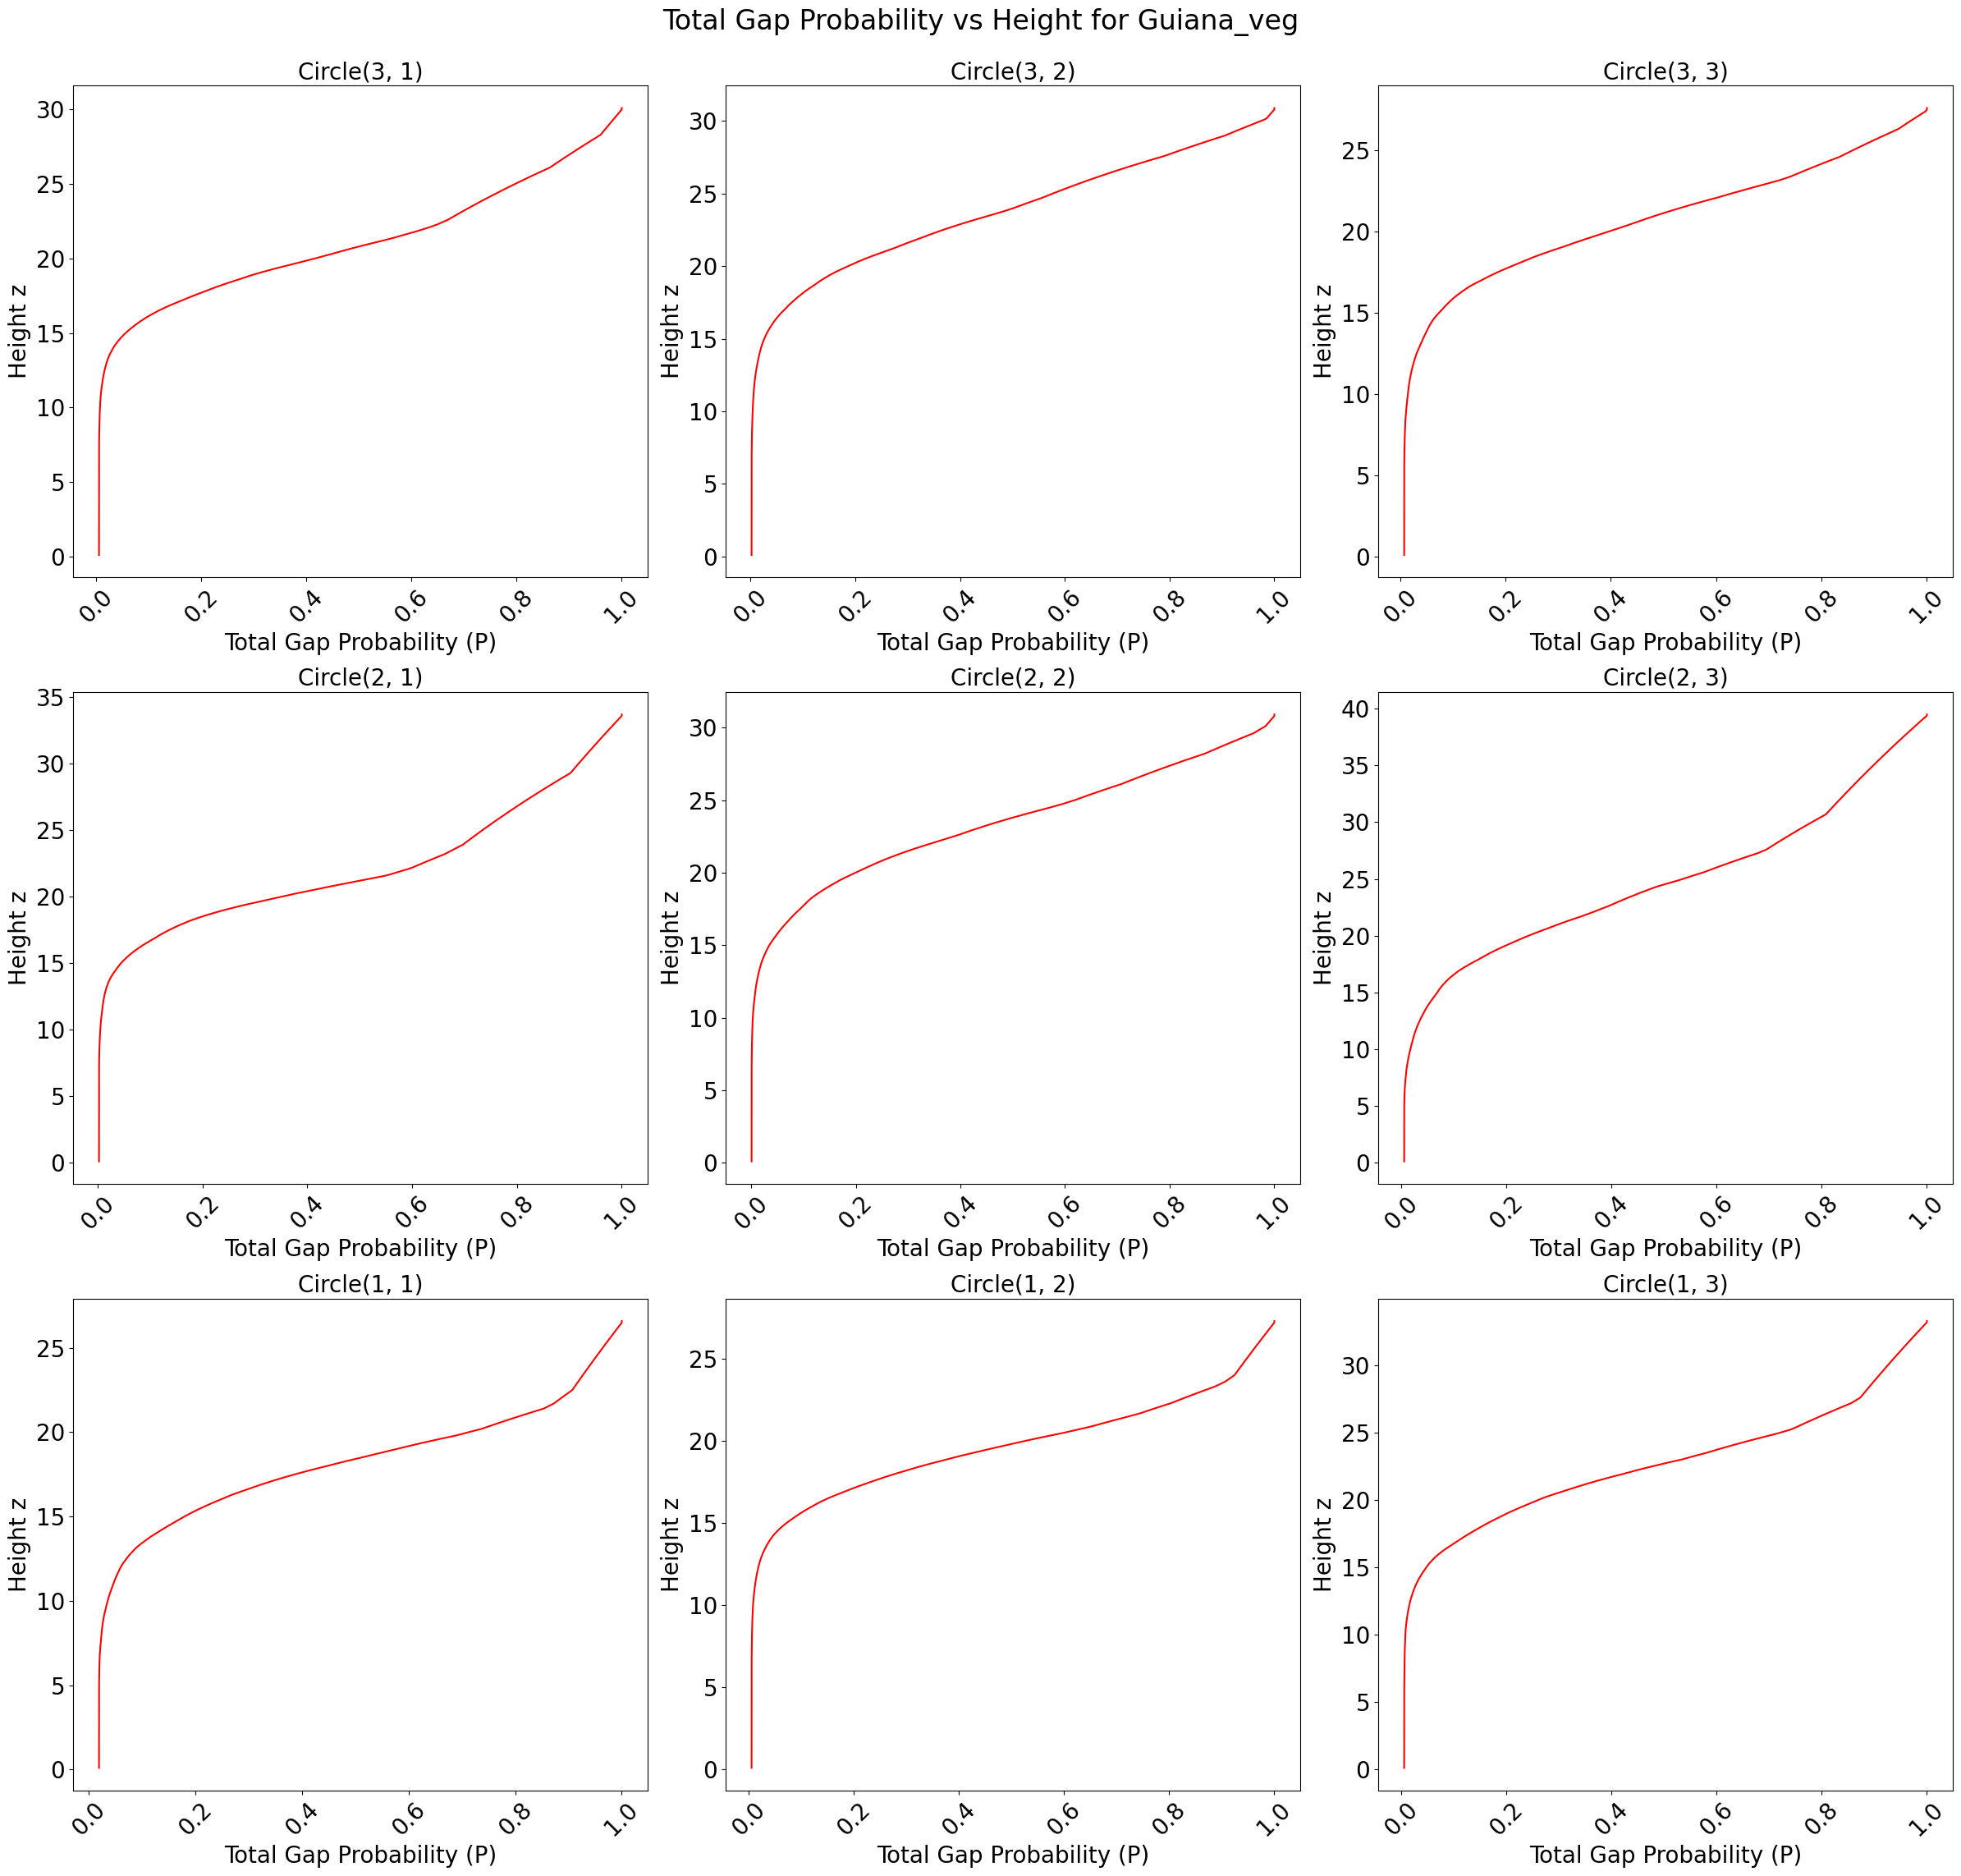

In [56]:
plot_gap_probability(guiana_leaf_pgap_df_list, "Guiana_leaf", circle_names, output_path)
plot_gap_probability(guiana_branch_pgap_df_list, "Guiana_veg", circle_names, output_path)

In [57]:
for circle in guiana_circle_objects:
    if circle.circle_name == "Circle(2, 3)":
        print(f"French Guiana: {circle.circle_name}\n")
        ratio_list = []
        for i, tree_index in enumerate(circle.tree_indices):
            print(f"{i + 1}. Tree {tree_index}:")
            each_tree_array = circle.Li_dz_branch[i]
            pixel_area = circle.pixel_area
            print(f"Pixel Area: {pixel_area}")
            dL_dz_per_tree = np.sum(each_tree_array)
            print(f"dL_dz_sum_per_tree: {dL_dz_per_tree}")
            print(f"dL_dz/pixel_area = {dL_dz_per_tree}/{pixel_area} = {dL_dz_per_tree/pixel_area}")
            dL_dz_per_tree_pixel_ratio = dL_dz_per_tree/pixel_area
            ratio_list.append(dL_dz_per_tree_pixel_ratio)
            print()
        
        print(ratio_list)

French Guiana: Circle(2, 3)

1. Tree 179:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 213.55486765673052
dL_dz/pixel_area = 213.55486765673052/870.9201694097964 = 0.2452060190562035

2. Tree 198:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 217.91540078685887
dL_dz/pixel_area = 217.91540078685887/870.9201694097964 = 0.25021283056808225

3. Tree 226:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 1353.6884565107553
dL_dz/pixel_area = 1353.6884565107553/870.9201694097964 = 1.5543197919369813

4. Tree 249:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 1467.9882027622978
dL_dz/pixel_area = 1467.9882027622978/870.9201694097964 = 1.68556000231011

5. Tree 296:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 3357.979984783984
dL_dz/pixel_area = 3357.979984783984/870.9201694097964 = 3.8556690988791935

6. Tree 311:
Pixel Area: 870.9201694097964
dL_dz_sum_per_tree: 461.44828530077103
dL_dz/pixel_area = 461.44828530077103/870.9201694097964 = 0.5298399342542319

7. Tree 315:
P

In [58]:
def get_total_LAI(circle_objects, path, site, type):
    circle_names = [circle.circle_name for circle in circle_objects]
    crown_volumes = [np.sum(circle.crown_vol_in_circle) for circle in circle_objects]
    pixel_area = np.array([circle.pixel_area for circle in circle_objects])

    if(type == "leaf"):
        circle_Fa = np.array([circle.new_Fa for circle in circle_objects])
    if(type == "branch"):
        circle_Fa = np.array([circle.Fa_b for circle in circle_objects])

    total_LAI = (crown_volumes*circle_Fa)/pixel_area

    total_LAI_df = pd.DataFrame()

    total_LAI_df['circle_names'] = circle_names
    total_LAI_df['crown_volumes'] = crown_volumes
    total_LAI_df['circle_Fa'] = circle_Fa
    total_LAI_df['pixel_area'] = pixel_area
    total_LAI_df['total_LAI'] = total_LAI

    if not os.path.exists(path):
        os.makedirs(path)

    filename = f'{site}_{type}_totalLAI.csv'

    total_LAI_df.to_csv(f'{path}{filename}', index=False)
    print(f'wrote to: {path}{filename}')

    return total_LAI_df

redwood_total_LAI_leaf_df = get_total_LAI(redwood_circle_objects, output_path + "totalLAI_csv/", "redwood", "leaf")
redwood_total_LAI_veg_df = get_total_LAI(redwood_circle_objects, output_path + "totalLAI_csv/", "redwood", "branch")
guiana_total_LAI_leaf_df = get_total_LAI(guiana_circle_objects, output_path + "totalLAI_csv/", "guiana", "leaf")
guiana_total_LAI_veg_df = get_total_LAI(guiana_circle_objects, output_path + "totalLAI_csv/", "guiana", "branch")

wrote to: C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/totalLAI_csv/redwood_leaf_totalLAI.csv
wrote to: C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/totalLAI_csv/redwood_branch_totalLAI.csv
wrote to: C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/totalLAI_csv/guiana_leaf_totalLAI.csv
wrote to: C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/totalLAI_csv/guiana_branch_totalLAI.csv


In [59]:
for circle in guiana_circle_objects:
    print(circle.circle_name)
    print("Circle Fa: ", circle.Fa_b)
    print("Tree Fa: ", circle.Fa_leaf_branch_per_tree)
    print()

Circle(3, 1)
Circle Fa:  4.25472635290666
Tree Fa:  [4.29042107 4.23754002 4.29365973 4.28054056 4.31695247 4.34179176
 4.30209356 4.38062924 4.35761022 4.21349342 4.28164644 4.294583
 4.36216297 4.30207673 4.30021103 4.24740559 4.27136928 4.19071564
 4.24398765 4.29464519 4.30962771 4.26875918 4.31463469 4.32120619
 4.26914996 4.306856   4.37124197 4.31764572 4.25159057]

Circle(3, 2)
Circle Fa:  4.248448795795204
Tree Fa:  [4.26559585 4.24992605 4.30884625 4.36739935 4.28164644 4.25638186
 4.1841593  4.27274867 4.40484947 4.2991597  4.27316995 4.26354277
 4.37598978 4.25946504 4.36315248 4.27389638 4.3280519  4.30218312
 4.24301298 4.26409364 4.28379651 4.29380077 4.41421286 4.30153346
 4.32492495 4.22740539 4.24666145 4.31308015 4.30344798 4.3055856
 4.41669518 4.35070597 4.2849934  4.23649799]

Circle(3, 3)
Circle Fa:  4.265292539001303
Tree Fa:  [4.30642001 4.27705792 4.30775575 4.24046157 4.30188151 4.29952537
 4.42475766 4.27144772 4.28987653 4.22319721 4.28223558 4.27582576
 4.

In [60]:
print("French Guiana:")

circle_LAI_df = pd.DataFrame()
circle_names = [circle.circle_name for circle in guiana_circle_objects]
crown_volumes = [np.sum(circle.crown_vol_in_circle) for circle in guiana_circle_objects]
circle_Fa = np.array([circle.new_Fa for circle in guiana_circle_objects])
pixel_area = np.array([circle.pixel_area for circle in guiana_circle_objects])
total_LAI = (crown_volumes*circle_Fa)/pixel_area

circle_LAI_df['circle_names'] = circle_names
circle_LAI_df['crown_volumes'] = crown_volumes
circle_LAI_df['total_LAI'] = total_LAI

pd.set_option('display.expand_frame_repr', False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(circle_LAI_df)

circle_LAI_df.to_csv(f'{output_path}French_Guiana_Circles_data.csv', index=False)

French Guiana:
   circle_names  crown_volumes  total_LAI
0  Circle(3, 1)    1491.890638   5.797349
1  Circle(3, 2)    2597.746338  10.094601
2  Circle(3, 3)    1557.758135   6.053304
3  Circle(2, 1)    2625.611745  10.202884
4  Circle(2, 2)    1978.810671   7.689475
5  Circle(2, 3)    5274.037182  20.494419
6  Circle(1, 1)     829.688875   3.224094
7  Circle(1, 2)    1059.152572   4.115769
8  Circle(1, 3)    2002.482818   7.781462


In [65]:
Circle_1_1_df = pd.DataFrame()
Circle_2_3_df = pd.DataFrame()

for circle in guiana_circle_objects:
    if circle.circle_name == "Circle(1, 1)":

        tree_indices = circle.tree_indices
        tree_heights = [guiana_tree_objects[tree_index - 1].tree_height for tree_index in circle.tree_indices]
        crown_radii = [guiana_tree_objects[tree_index - 1].crown_d2 for tree_index in circle.tree_indices]
        crown_volume = [guiana_tree_objects[tree_index - 1].crown_volume for tree_index in circle.tree_indices]

        Circle_1_1_df['tree_index'] = tree_indices
        Circle_1_1_df['tree_heights'] = tree_heights
        Circle_1_1_df['crown_radii'] = crown_radii
        Circle_1_1_df['crown_volume'] = crown_volume

        pd.set_option('display.expand_frame_repr', False)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(df[['tree_index', 'tree_heights', 'crown_radii', 'crown_volume']])

    Circle_1_1_df.to_csv(f'{output_path}Circle(1, 1)_tree_metrics.csv', index=False)

    if circle.circle_name == "Circle(2, 3)":

        tree_indices = circle.tree_indices
        tree_heights = [guiana_tree_objects[tree_index - 1].tree_height for tree_index in circle.tree_indices]
        crown_radii = [guiana_tree_objects[tree_index - 1].crown_d2 for tree_index in circle.tree_indices]
        crown_volume = [guiana_tree_objects[tree_index - 1].crown_volume for tree_index in circle.tree_indices]
        print(crown_radii)

        Circle_2_3_df['tree_index'] = tree_indices
        Circle_2_3_df['tree_heights'] = tree_heights
        Circle_2_3_df['crown_radii'] = crown_radii
        Circle_2_3_df['crown_volume'] = crown_volume

        pd.set_option('display.expand_frame_repr', False)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(df[['tree_index', 'tree_heights', 'crown_radii', 'crown_volume']])

    Circle_2_3_df.to_csv(f'{output_path}Circle(2, 3)_tree_metrics.csv', index=False)



[0.797399, 0.823172, 1.48963, 1.76971, 2.10349, 1.05555, 0.918111, 1.26549, 2.31212, 0.870041, 1.1728, 0.747028, 2.86014, 0.967815, 1.73269, 3.65266, 1.1361, 1.54087, 1.02664, 4.7767, 0.713651, 3.43696, 2.20593, 10.3237, 1.98026, 1.29106, 1.15805, 0.87663, 0.915288, 2.85217, 1.07225]
    tree_index  tree_heights  crown_radii  crown_volume
0           81     18.402470     1.641310     41.009177
1           83     21.362250     2.083110     76.956336
2          101     26.422740     3.135020    208.567400
3          104     10.748925     0.936200      7.466279
4          124     19.767110     1.820470     52.952498
5          125     12.778135     1.043900     11.376905
6          126     14.554065     1.227860     17.766330
7          145     13.554855     1.142610     14.771087
8          146     21.631020     2.196290     85.926396
9          149     11.500675     0.944336      8.304965
10         164      9.561865     0.883344      5.782432
11         167     19.720150     1.785890  

In [62]:
import sympy as sp
from IPython.display import display, Math

# Define symbolic variables
Fa, r, h, b, i = sp.symbols('Fa r h b i')
z_i = sp.Function('z')(i)

# Define the symbolic expression
numerator = z_i - h
Li_dz_leaf_per_range_single = Fa * sp.pi * r**2 * sp.Abs(1 - (numerator / b)**2)

# Define numerical values
numerical_values = {
    Fa: 1.5,
    r: 2.0,
    h: 10,
    b: 3.0
}

# Create LaTeX strings
latex_formula = sp.latex(Li_dz_leaf_per_range_single)
latex_formula_with_numbers = sp.latex(Li_dz_leaf_per_range_single.subs(numerical_values))

# Display the LaTeX formulas
display(Math(r'Original Formula: %s' % latex_formula))
display(Math(r'Formula with Numbers: %s' % latex_formula_with_numbers))

<IPython.core.display.Math object>

<IPython.core.display.Math object>